<a href="https://colab.research.google.com/github/m-abbas-ansari/SuperResolution-DEMs/blob/main/Network-Definition-Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q wandb rasterio kornia piq

import os
from google.colab import drive
drive.mount('./gdrive')

In [ ]:
!cp -r gdrive/Shareddrives/TeamDriveForJmi/SIH/Dataset/npy/train_set .
print(f"\nSuccessfully copied train dataset with {len(os.listdir('train_set'))} DEMs")
!cp -r gdrive/Shareddrives/TeamDriveForJmi/SIH/Dataset/npy/test_set .
print(f"Successfully copied test dataset with {len(os.listdir('test_set'))} DEMs")


Successfully copied train dataset with 129 DEMs
Successfully copied test dataset with 10 DEMs


In [ ]:
!cp -r gdrive/Shareddrives/TeamDriveForJmi/SIH/Kernels .
print(f"Successfully copied {len(os.listdir('Kernels/results'))} Kernels")

Successfully copied 70 Kernels


#### Data Utilities and Loader

In [ ]:
import os
# import shutil
# import glob

# os.makedirs('SDEM/train', exist_ok=True)
# os.makedirs('SDEM/val', exist_ok=True)

# dem_paths = glob.glob('SDEM/*.asc')
# train_dems, val_dems = dem_paths[:30], dem_paths[30:]

# for dem in train_dems:
#   shutil.move(dem, 'SDEM/train')

# for dem in val_dems:
#   shutil.move(dem, 'SDEM/val')

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy.io import loadmat
from scipy.ndimage import correlate
from torchvision import transforms
from torch.utils.data import DataLoader
import rasterio as rio
import glob

def numeric_kernel(im, kernel, scale_factor, output_shape):
    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    out_im = correlate(im, kernel)
    # print(out_im.shape)
    #print(np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None].shape)
    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None],
           np.round(np.linspace(0, im.shape[1] - 1 / scale_factor[1], output_shape[1])).astype(int)]

def normalize(im):
    MIN_H = -500.0
    MAX_H = 10000.0
    return (im - MIN_H)/(MAX_H-MIN_H)

class DemDataset(Dataset):
    """DEM dataset."""

    def __init__(self, root_dir, kernel_dir, transform=transforms.Compose([transforms.ToTensor()])):
        """
        Args:
            root_dir (string): Directory with all the DEMs.
            kernel_dir (string): Directory with all the kernel DEMs.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        dem_list = glob.glob(root_dir + '/*.npy')
        # print(dem_list)
        # self.dems = [normalize(np.load(dem_path)) for dem_path in dem_list] 
        self.dems = dem_list
        self.downsampler = torch.nn.Upsample(scale_factor=0.5, mode='bilinear')
        kernel_list = glob.glob(kernel_dir + '/*.mat')
        # print(kernel_list)
        self.kernels = [loadmat(k)["Kernel"] for k in kernel_list]

    def __len__(self):
        return len(self.dems)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        im = normalize(np.load(self.dems[idx]))
        HR = self.RandomCrop(im, 256).astype(np.float32) 
       

        if idx % 3 == 0: # bilinear downsampling
          HR = self.transform(HR) # to tensor
          LR = self.downsampler(HR.unsqueeze(0)).squeeze().unsqueeze(0)
        else:
          k = self.kernels[np.random.randint(0, len(self.kernels))]
          LR = numeric_kernel(HR, k, [0.5,0.5], (128, 128)).astype(np.float32) 
          HR = self.transform(HR)
          LR = self.transform(LR)

            
        sample = {'HR': HR, 'LR': LR}        
        return sample
    
    
    def RandomCrop(self,image, output_size):
        h, w = image.shape[:2]
        new_h, new_w = (output_size, output_size)

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, left: left + new_w]

        return image

In [ ]:
train_data = DemDataset("train_set", "Kernels/results", transform = transforms.Compose([transforms.ToTensor()]))
train_dl = DataLoader(dataset=train_data, batch_size=4, shuffle=True)

val_data = DemDataset("test_set", "Kernels/results", transform = transforms.Compose([transforms.ToTensor()]))
val_dl = DataLoader(dataset=val_data, batch_size=4)

In [ ]:
batch = next(iter(train_dl))
hr = batch['HR']
lr = batch['LR']

In [ ]:
lr.size(), hr.size()

(torch.Size([4, 1, 128, 128]), torch.Size([4, 1, 256, 256]))

In [ ]:
lr = F.interpolate(hr, scale_factor = 0.5, mode='bilinear')
lr.size(), hr.size()

(torch.Size([4, 1, 128, 128]), torch.Size([4, 1, 256, 256]))

#### Imports

In [ ]:
import numpy as np
import os, pdb
import argparse
#from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import time
import imp
import os
import cv2
import random
import numpy as np
from functools import partial
from matplotlib import pyplot
import functools
import torch
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
import rasterio as rio
import glob
import wandb

In [ ]:
!pip install -q kornia piq
from kornia.filters.sobel import Sobel

#### Experimentation with Sobel Operator

In [ ]:
import torch
import torch.nn as nn 

# PyTorch implementation of Sobel Operator by https://github.com/chaddy1004/sobel-operator-pytorch/
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=False)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x

In [ ]:
b = next(iter(train_dl))
lr, hr = F.interpolate(b['HR'], scale_factor = 0.5, mode='bilinear'), b['HR']

In [ ]:
sobel = Sobel()

In [ ]:
edges = sobel(hr)

In [ ]:
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (8,8)

hr_i = hr[1].squeeze()
edges_i = edges[1].squeeze()

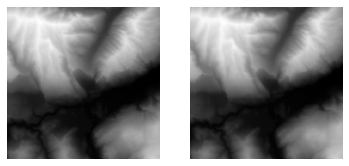

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Sobel Operation')
ax1.axis('off')
ax1.imshow(hr[0].squeeze(), cmap='Greys_r')
ax2.axis('off')
ax2.imshow(lr[0].squeeze(), cmap='Greys_r')

In [ ]:
hr.size()

torch.Size([8, 1, 512, 512])

In [ ]:
edges.size()

torch.Size([8, 1, 510, 510])

#### Experiments with Bicubic Upsampling

In [ ]:
upsampler = nn.Upsample(scale_factor=4, mode='bicubic')

In [ ]:
sr = upsampler(lr)
sr.size()

torch.Size([8, 1, 512, 512])

In [ ]:
lr_i = lr[0].squeeze()
sr_i = sr[0].squeeze()

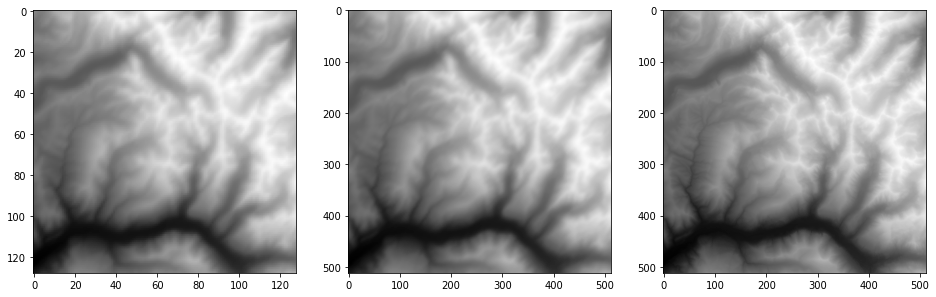

In [ ]:
plt.rcParams["figure.figsize"] = (16,16)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(lr_i, cmap='Greys_r')
ax2.imshow(sr_i, cmap='Greys_r')
ax3.imshow(hr_i, cmap='Greys_r')

In [ ]:
sr_edges = sobel(sr)

In [ ]:
sr_edges_i = sr_edges[0].squeeze()

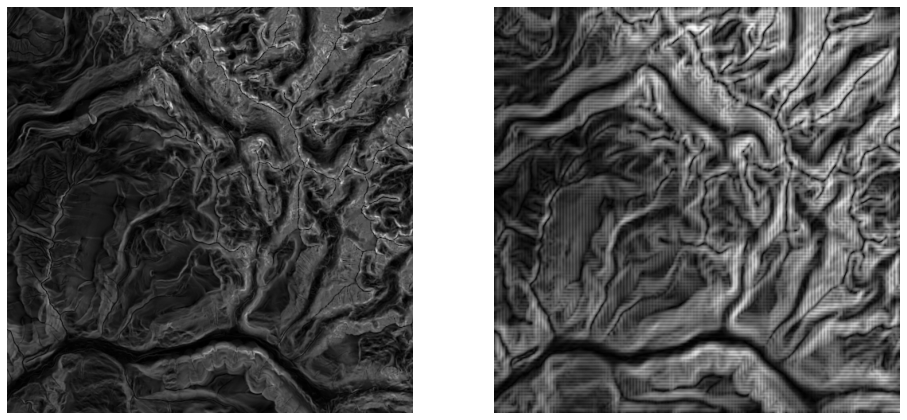

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Sobel Operation')
ax1.axis('off')
ax1.imshow(edges_i, cmap='Greys_r')
ax2.axis('off')
ax2.imshow(sr_edges_i, cmap='Greys_r')

In [ ]:
bil_edges_i = sobel(nn.Upsample(scale_factor=4, mode='bilinear')(lr))[0].squeeze()

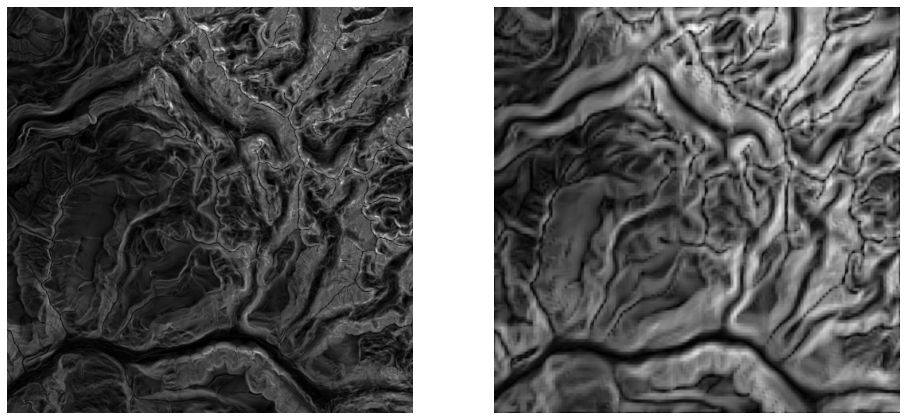

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Sobel Operation')
ax1.axis('off')
ax1.imshow(edges_i, cmap='Greys_r')
ax2.axis('off')
ax2.imshow(bil_edges_i, cmap='Greys_r')

In [ ]:
bil_edges = sobel(nn.Upsample(scale_factor=4, mode='bilinear')(lr))

In [ ]:
bicubic_l1 = torch.sum(torch.abs(edges - sr_edges))/(512*512)
bilinear_l1 = torch.sum(torch.abs(edges - bil_edges))/(512*512)

bicubic_l1, bilinear_l1

(tensor(0.2224), tensor(0.2302))

tensor(0.)

(tensor(0.0280), tensor(0.0290))

In [ ]:
x2_upsampler = nn.Upsample(scale_factor=2, mode='bilinear')
bil_x2_edges = sobel(x2_upsampler(x2_upsampler(lr)))

In [ ]:
bilinear_x2_l1 = torch.sum(torch.abs(edges - bil_x2_edges))/(512*512)
bilinear_x2_l1

tensor(0.0770)

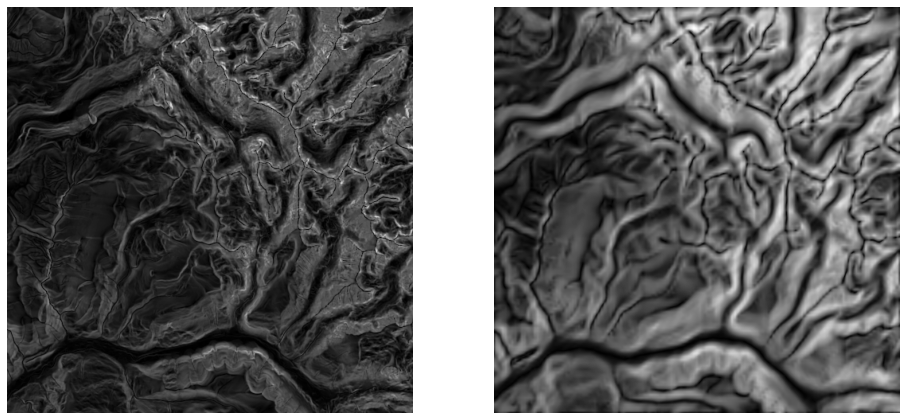

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Sobel Operation')
ax1.axis('off')
ax1.imshow(edges_i, cmap='Greys_r')
ax2.axis('off')
ax2.imshow(bil_x2_edges[0].squeeze(), cmap='Greys_r')

#### Loss Functions & Metrics

In [ ]:
import torch
import torch.nn as nn 

# # PyTorch implementation of Sobel Operator by https://github.com/chaddy1004/sobel-operator-pytorch/
# class Sobel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

#         Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
#         Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
#         G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
#         G = G.unsqueeze(1)
#         self.filter.weight = nn.Parameter(G, requires_grad=False)

#     def forward(self, img):
#         x = self.filter(img)
#         x = torch.mul(x, x)
#         x = torch.sum(x, dim=1, keepdim=True)
#         x = torch.sqrt(x)
#         return x

class gradientAwareLoss(nn.Module): 
  '''
  Takes in 2 DEMs. Computes their gradient/edge features using 
  sobel filter and computes mean absolute error between them.
  '''
  def __init__(self):
    super().__init__()
    self.sobelFilter = Sobel().to('cuda')
    self.l1Loss = nn.L1Loss().to('cuda')

  def forward(self, hr, sr):
    hrEdgeMap = self.sobelFilter(hr)
    srEdgeMap = self.sobelFilter(sr)
    return self.l1Loss(hrEdgeMap, srEdgeMap)  

In [ ]:
'''SSIM Loss function taken from: https://github.com/Po-Hsun-Su/pytorch-ssim'''

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)*2/float(2*sigma*2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2
    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2
    C1 = 0.01**2
    C2 = 0.03**2
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            self.window = window
            self.channel = channel
        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
import math

def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse))

#### Encoder definiton

In [ ]:
class EfficientAttention(nn.Module):

    def __init__(self, in_channels, key_channels, head_count, value_channels):
        super().__init__()
        self.in_channels = in_channels
        self.key_channels = key_channels
        self.head_count = head_count
        self.value_channels = value_channels

        self.keys = nn.Conv2d(in_channels, key_channels, 1)
        self.queries = nn.Conv2d(in_channels, key_channels, 1)
        self.values = nn.Conv2d(in_channels, value_channels, 1)
        self.reprojection = nn.Conv2d(value_channels, in_channels, 1)

    def forward(self, input_):
        n, _, h, w = input_.size()
        keys = self.keys(input_).reshape((n, self.key_channels, h * w))
        queries = self.queries(input_).reshape(n, self.key_channels, h * w)
        values = self.values(input_).reshape((n, self.value_channels, h * w))
        head_key_channels = self.key_channels // self.head_count
        head_value_channels = self.value_channels // self.head_count

        attended_values = []
        for i in range(self.head_count):
            key = F.softmax(keys[
                :,
                i * head_key_channels: (i + 1) * head_key_channels,
                :
            ], dim=2)
            query = F.softmax(queries[
                :,
                i * head_key_channels: (i + 1) * head_key_channels,
                :
            ], dim=1)
            value = values[
                :,
                i * head_value_channels: (i + 1) * head_value_channels,
                :
            ]
            context = key @ value.transpose(1, 2)
            attended_value = (
                context.transpose(1, 2) @ query
            ).reshape(n, head_value_channels, h, w)
            attended_values.append(attended_value)

        aggregated_values = torch.cat(attended_values, dim=1)
        reprojected_value = self.reprojection(aggregated_values)
        attention = reprojected_value + input_

        return attention

In [ ]:
def initialize_weights(net_l, scale=1):
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias.data, 0.0)


def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)

class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDBAttention(nn.Module):
    '''Residual in Residual Dense Block with Efficient Attention'''

    def __init__(self, nf, gc=32):
        super(RRDBAttention, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.eat1 = EfficientAttention(nf, 64, 4, 64)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.eat2 = EfficientAttention(nf, 64, 4, 64)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)
        self.eat3 = EfficientAttention(nf, 64, 4, 64)

    def forward(self, x):
        out = self.eat1( self.RDB1(x) )
        out = self.eat2( self.RDB2(out) )
        out = self.eat3( self.RDB3(out) )
        return out * 0.2 + x

In [ ]:
with torch.no_grad():
  x = np.random.random((1, 256, 32, 32))
  x = torch.tensor(x, dtype=torch.float32)
  print(x.size())
  print(EfficientAttention(256, 64, 1, 64)(x).size())

torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32])


In [ ]:
downsampler = nn.Upsample(scale_factor = 0.5, mode='bilinear')

In [ ]:
batch = next(iter(train_dl))
hr = batch['HR']
lr = downsampler(hr)

In [ ]:
with torch.no_grad():
  print(f'input_shape : {lr.size()}')
  x = nn.Upsample(scale_factor=2, mode='bilinear')(lr)
  print(f'upsampled shape : {x.size()}')
  conv_out = nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1)(x)
  print(f'inital output conv shape : {conv_out.size()}')
  rrdb_1_out = RRDB(64, 32)(conv_out)
  print(f'rrdb_1_out: {rrdb_1_out.size()}')
  pooled_output = nn.MaxPool2d(3, stride=2, padding=1)(rrdb_1_out)
  print(f'pooled_output: {pooled_output.size()}')
  residual_output = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding =1)(lr + pooled_output)
  print(f'residual_otuput: {residual_output.size()}')
  rrdb_2_out = RRDB(128, 32)(residual_output)
  print(f'rrdb_2_out: {rrdb_2_out.size()}')
  pooled_output = nn.MaxPool2d(3, stride=2, padding=1)(rrdb_2_out)
  print(f'pooled_output: {pooled_output.size()}')
  conv_out = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)(pooled_output)
  print(f'conv_out: {conv_out.size()}')
  rrdb_3_out = RRDB(256, 32)(conv_out)
  print(f'rrdb_3_out: {rrdb_3_out.size()}')


input_shape : torch.Size([4, 1, 128, 128])
upsampled shape : torch.Size([4, 1, 256, 256])
inital output conv shape : torch.Size([4, 64, 256, 256])
rrdb_1_out: torch.Size([4, 64, 256, 256])
pooled_output: torch.Size([4, 64, 128, 128])
residual_otuput: torch.Size([4, 128, 128, 128])
rrdb_2_out: torch.Size([4, 128, 128, 128])
pooled_output: torch.Size([4, 128, 64, 64])
conv_out: torch.Size([4, 256, 64, 64])
rrdb_3_out: torch.Size([4, 256, 64, 64])


In [ ]:
class EncoderWithAttention(nn.Module):
    def __init__(self, nf, scale_factor):
        super().__init__()
        self.scale_factor = scale_factor
        self.upscaler = nn.Upsample(scale_factor=self.scale_factor, mode='bilinear')
        self.lrelu = nn.LeakyReLU()

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv_1 = nn.Conv2d(1, nf, kernel_size=3, stride=1, padding=1) 
        self.rrdb_1 = RRDBAttention(nf, 32)
        self.conv_res = nn.Conv2d(1, nf, kernel_size=3, stride=1, padding=1) 
        self.conv_2 = nn.Conv2d(nf, nf*2, kernel_size=3, stride=1, padding=1) 
        self.rrdb_2 = RRDBAttention(nf*2, 32)
        self.conv_3 = nn.Conv2d(nf*2, nf*4, kernel_size=3, stride=1, padding=1) 
        self.rrdb_3 = RRDBAttention(nf*4, 32)
        self.conv_4 = nn.Conv2d(nf*4, nf*8, kernel_size=3, stride=1, padding=1)
        self.rrdb_4 = RRDBAttention(nf*8, 32)

    def forward(self, x):
        feats = []

        upscaled = self.upscaler(x) # 1 x 256 x 256
        res_in = self.conv_res(x)
        x = self.lrelu(self.conv_1(upscaled))
        x = self.rrdb_1(x)
        feats.append(x) # 64 x 256 x 256
        pooled = self.maxpool(x)
        x = self.lrelu(self.conv_2(pooled + res_in)) # residual connection from lr input
        x = self.rrdb_2(x)
        feats.append(x) # 128 x 64 x 64
        pooled = self.maxpool(x)
        x = self.lrelu(self.conv_3(pooled))
        x = self.rrdb_3(x)
        feats.append(x) # 256 x 64 x 64 
        pooled = self.maxpool(x)
        x = self.lrelu(self.conv_4(pooled))
        x = self.rrdb_4(x)
        feats.append(x) # 512 x 32 x 32

        return feats

In [ ]:
enc = EncoderWithAttention(32, 2).to('cuda')

In [ ]:
with torch.no_grad():
  batch = next(iter(train_dl))
  hr = batch['HR']
  lr = F.interpolate(hr, scale_factor=0.5, mode='bilinear')
  out_feats = enc(lr.cuda())
  for f in out_feats:
    print(f.size())

torch.Size([8, 32, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])


#### Decoder and Final U-Net Definiton

In [ ]:
!git clone https://github.com/seungjunlee96/DepthwiseSeparableConvolution_Pytorch.git
%cd DepthwiseSeparableConvolution_Pytorch/
!python3 setup.py install --user

Cloning into 'DepthwiseSeparableConvolution_Pytorch'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 105 (delta 57), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (105/105), 312.97 KiB | 2.50 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/DepthwiseSeparableConvolution_Pytorch
running install
running bdist_egg
running egg_info
creating Depthwise_Separable_Convolution_Pytorch.egg-info
writing Depthwise_Separable_Convolution_Pytorch.egg-info/PKG-INFO
writing dependency_links to Depthwise_Separable_Convolution_Pytorch.egg-info/dependency_links.txt
writing top-level names to Depthwise_Separable_Convolution_Pytorch.egg-info/top_level.txt
writing manifest file 'Depthwise_Separable_Convolution_Pytorch.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'Depthwise_Separable_Convolution_Pytorch.egg-info/SOURCES.txt'
installing library code to 

In [ ]:
from DepthwiseSeparableConvolution import depthwise_separable_conv

class ERAM(nn.Module):
    def __init__(self, channel_begin, dimension):
        super().__init__()
        self.conv = nn.Conv2d(channel_begin, channel_begin, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(dimension)
        
        self.conv1 = nn.Conv2d(channel_begin, channel_begin//2, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(channel_begin//2, channel_begin, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(channel_begin, channel_begin, kernel_size=3, stride=1, padding=1)

        self.dconv = depthwise_separable_conv(channel_begin, channel_begin, kernel_size = 3, padding = 1, bias=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        si_ca = self.avgpool(x) + torch.var_mean(x, dim=(2,3))[0].unsqueeze(2).unsqueeze(2)
        mi_ca = self.conv2(self.relu(self.conv1(si_ca)))

        mi_sa = self.conv3(self.relu(self.dconv(x)))

        return self.sigmoid(mi_ca+mi_sa) * x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, nf, dimension):
        super().__init__()

        self.lrelu = nn.LeakyReLU()

        self.eram_1 = ERAM(nf, dimension)
        self.conv_1 = nn.Conv2d(nf, nf//2, kernel_size=3, stride=1, padding=1)
        self.up_1 = nn.ConvTranspose2d(nf//2, nf//2, kernel_size=2, stride=2)
        
        self.rrdb_1 = RRDBAttention(nf, 32)

        self.eram_2 = ERAM(nf, dimension*2)
        self.conv_2 = nn.Conv2d(nf, nf//4, kernel_size=3, stride=1, padding=1)
        self.up_2 = nn.ConvTranspose2d(nf//4, nf//4, kernel_size=2, stride=2)

        self.rrdb_2 = RRDBAttention(nf//2, 32)

        self.eram_3 = ERAM(nf//2, dimension*4)
        self.conv_3 = nn.Conv2d(nf//2, nf//8, kernel_size=3, stride=1, padding=1)
        self.up_3 = nn.ConvTranspose2d(nf//8, nf//8, kernel_size=2, stride=2)

        self.rrdb_3 = RRDBAttention(nf//4, 32)

        self.eram_4 = ERAM(nf//4, dimension*8)
        self.conv_4 = nn.Conv2d(nf//4, 1, kernel_size=3, stride=1, padding=1)

    
    def forward(self, feats):
        x = self.lrelu(self.up_1(self.conv_1(self.eram_1(feats[-1]))))
        x = torch.cat((x, feats[-2]), dim=1)
        x = self.rrdb_1(x)
        x = self.lrelu(self.up_2(self.conv_2(self.eram_2(x)))) 
        x = torch.cat((x, feats[-3]), dim=1)
        x = self.rrdb_2(x)
        x = self.lrelu(self.up_3(self.conv_3(self.eram_3(x))))
        x = torch.cat((x, feats[0]), dim=1)
        x = self.rrdb_3(x)
        x = self.conv_4(self.eram_4(x))
        return x

In [ ]:
class USRNet(nn.Module):
  def __init__(self, scale_factor, enc_filters, dec_filters, dec_dim):
    super().__init__()
    self.encoder = EncoderWithAttention(enc_filters, scale_factor)
    self.decoder = Decoder(dec_filters, dec_dim)
    self.relu = nn.ReLU()
  def forward(self, lr):
    out_feats = self.encoder(lr)
    sr = self.decoder(out_feats)
    return sr

##### Decoder Experimentation

In [ ]:
with torch.no_grad():
  x = ERAM(256, 32).cuda()(out_feats[-1])
  print(f'eram_1: {x.size()}')

avgpool size: torch.Size([4, 256, 1, 1])
eram_1: torch.Size([4, 256, 32, 32])


In [ ]:
dec = Decoder(256, 32).cuda() 

In [ ]:
with torch.no_grad():
  dec_out = dec(out_feats)

In [ ]:
dec_out.size()

torch.Size([4, 1, 256, 256])

In [ ]:
net = USRNet(2, 32, 256, 32).cuda()

In [ ]:
with torch.no_grad():
  out = net(lr.cuda())

In [ ]:
lr.size(), out.size()

(torch.Size([4, 1, 128, 128]), torch.Size([4, 1, 256, 256]))

In [ ]:
D = Discriminator_VGG_128(1,64)
D.cuda()

In [ ]:
with torch.no_grad():
  disc_out = D(sr)

In [ ]:
disc_out.size()

torch.Size([4, 1])

#### Discriminator

In [ ]:
class Discriminator_VGG_128(nn.Module):
    def __init__(self, in_nc, nf):
        super(Discriminator_VGG_128, self).__init__()
        self.conv0_0 = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.conv0_1 = nn.Conv2d(nf, nf, 4, 2, 1, bias=False)
        self.bn0_1 = nn.BatchNorm2d(nf, affine=True)
        self.conv1_0 = nn.Conv2d(nf, nf * 2, 3, 1, 1, bias=False)
        self.bn1_0 = nn.BatchNorm2d(nf * 2, affine=True)
        self.conv1_1 = nn.Conv2d(nf * 2, nf * 2, 4, 2, 1, bias=False)
        self.bn1_1 = nn.BatchNorm2d(nf * 2, affine=True)
        self.conv2_0 = nn.Conv2d(nf * 2, nf * 4, 3, 1, 1, bias=False)
        self.bn2_0 = nn.BatchNorm2d(nf * 4, affine=True)
        self.conv2_1 = nn.Conv2d(nf * 4, nf * 4, 4, 2, 1, bias=False)
        self.bn2_1 = nn.BatchNorm2d(nf * 4, affine=True)
        self.conv3_0 = nn.Conv2d(nf * 4, nf * 8, 3, 1, 1, bias=False)
        self.bn3_0 = nn.BatchNorm2d(nf * 8, affine=True)
        self.conv3_1 = nn.Conv2d(nf * 8, nf * 8, 4, 2, 1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(nf * 8, affine=True)
        self.conv4_0 = nn.Conv2d(nf * 8, nf * 8, 3, 1, 1, bias=False)
        self.bn4_0 = nn.BatchNorm2d(nf * 8, affine=True)
        self.conv4_1 = nn.Conv2d(nf * 8, nf * 8, 4, 2, 1, bias=False)
        self.bn4_1 = nn.BatchNorm2d(nf * 8, affine=True)
        self.linear1 = nn.Linear(nf * 8 * 8 * 8, 100)
        self.linear2 = nn.Linear(100, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.lrelu(self.conv0_0(x))
        fea = self.lrelu(self.bn0_1(self.conv0_1(fea)))
        fea = self.lrelu(self.bn1_0(self.conv1_0(fea)))
        fea = self.lrelu(self.bn1_1(self.conv1_1(fea)))
        fea = self.lrelu(self.bn2_0(self.conv2_0(fea)))
        fea = self.lrelu(self.bn2_1(self.conv2_1(fea)))
        fea = self.lrelu(self.bn3_0(self.conv3_0(fea)))
        fea = self.lrelu(self.bn3_1(self.conv3_1(fea)))
        fea = self.lrelu(self.bn4_0(self.conv4_0(fea)))
        fea = self.lrelu(self.bn4_1(self.conv4_1(fea)))
        fea = fea.view(fea.size(0), -1)
        fea = self.lrelu(self.linear1(fea))
        out = self.linear2(fea)
        return out

#### Training and Validation 

In [ ]:
#network
network = USRNet(2, 32, 256, 32)

network = network.to('cuda')

In [ ]:
import gc
gc.collect()
network.eval()
optimizer.zero_grad()
del network
gc.collect()

0

In [ ]:
# discriminator
discriminator = Discriminator_VGG_128(1,64)
discriminator = discriminator.to('cuda')

In [ ]:
network_params = sum([p.numel() for p in network.parameters()])
# discriminator_params = sum([p.numel() for p in discriminator.parameters()])
print(f'number of parameters in generator = {network_params:,}')
# print(f'number of parameters in discriminator = {discriminator_params:,}')

number of parameters in generator = 18,179,745


In [ ]:
# loss
from piq import MultiScaleSSIMLoss, InformationWeightedSSIMLoss, MultiScaleGMSDLoss

bceLoss = nn.BCELoss().to('cuda')
l1Loss = nn.L1Loss().to('cuda')                       # MAE Reconstruction
ssimLoss = SSIM().to('cuda')                          # Structural Similarity
m_ssimLoss = MultiScaleSSIMLoss().to('cuda')          # Multiscale Structural Similarity
iwssimLoss = InformationWeightedSSIMLoss().to('cuda') # Information-Weighted SSIM
gmsdLoss = MultiScaleGMSDLoss().to('cuda')            # Multi-Scale Gradient Magnitude Similarity Deviation
edgeLoss = gradientAwareLoss().to('cuda')             # MAE between edge-maps computed through sobel filter

In [ ]:
#utilities
upsampler = nn.Upsample(scale_factor = 2, mode='bilinear')
edge_detector = Sobel().to('cuda')

In [ ]:
# Adam optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=0.000001)
# optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.00001)

In [ ]:
# Loading weights

network.load_state_dict(torch.load("gdrive/Shareddrives/TeamDriveForJmi/SIH/saved_models/usrnet/usrnet_att_large_data_0.pkl"), strict=False)

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import wandb

wandb.init(project="sr-unet", name="ea_large_unet-6")

wandb: Currently logged in as: m-abbas-ansari. Use `wandb login --relogin` to force relogin


In [ ]:
num_epochs = 500
num_train_batches = float(len(train_dl))
num_val_batches = float(len(val_dl))

In [ ]:
@torch.no_grad()
def bilinear_rec_loss(lrdem, hrdem):
  '''
  Args:
    lrdem (batched tensor)
    hrdem (batched tensor) 

  Returns:
    loss (float): Combination of l1, ssim and gradient-aware-loss 
    between hrdem and srdem geneated through bilinear upsampling 
  '''
  srdem = upsampler(lrdem)
  l1_loss = l1Loss(hrdem, srdem)
  ssim_loss = m_ssimLoss(F.relu(hrdem), F.relu(srdem))
  # iwssim_loss = iwssimLoss(F.relu(hrdem), F.relu(srdem))
  gmsd_loss = gmsdLoss(F.relu(hrdem), F.relu(srdem))
  edge_loss = edgeLoss(hrdem, srdem)
  return (l1_loss + 100*(ssim_loss + gmsd_loss + edge_loss)).item()

In [ ]:
def rec_loss(hrdem, srdem):
  l1_loss = l1Loss(hrdem, srdem)
  ssim_loss = m_ssimLoss(F.relu(hrdem), F.relu(srdem))
  # iwssim_loss = iwssimLoss(F.relu(hrdem), F.relu(srdem))
  gmsd_loss = gmsdLoss(F.relu(hrdem), F.relu(srdem))
  edge_loss = edgeLoss(hrdem, srdem)
  return (l1_loss + 100*(ssim_loss + gmsd_loss + edge_loss)).item()

In [ ]:
def train_one_epoch_ff(epoch): # feed forward training
  print(f"\nEpoch {epoch}: ", end ="")

  G_l1_loss = 0.
  G_ssim_loss = 0.
  # G_iwssim_loss = 0.
  G_gmsd_loss = 0.
  G_edge_loss = 0.
  G_rec_loss = 0. # reconstruction loss computed for SRDEM generated by G
  B_rec_loss = 0. # reconstruction loss computed for SRDEM generated by bilinear upsampling

  network.train()
  for batch in tqdm(train_dl):
    optimizer.zero_grad()
    batch_hr = batch['HR'] 
    batch_lr = F.interpolate(batch_hr, scale_factor=0.5, mode='bilinear')

    lr_images = batch_lr.to("cuda")
    hr_images = batch_hr.to("cuda")
    predicted_hr_images = network(lr_images)


    # reconstruction loss
    g_l1_loss = l1Loss(hr_images*10500, predicted_hr_images*10500)
    g_ssim_loss = m_ssimLoss(F.relu(hr_images), F.relu(predicted_hr_images))
    # g_iwssim_loss = iwssimLoss(hr_images, predicted_hr_images)
    g_gmsd_loss = gmsdLoss(F.relu(hr_images), F.relu(predicted_hr_images))
    g_edge_loss = edgeLoss(hr_images*10500, predicted_hr_images*10500)
    g_reconstruction_loss = g_l1_loss + 100*(g_edge_loss + g_ssim_loss + g_gmsd_loss)

    g_loss = g_reconstruction_loss
    g_loss.backward() # network backprop
    optimizer.step()

    # running sum of all network losses  
    G_l1_loss += g_l1_loss.item()
    G_ssim_loss += g_ssim_loss.item()
    # G_iwssim_loss += g_iwssim_loss.item() 
    G_gmsd_loss += g_gmsd_loss.item()
    G_edge_loss += g_edge_loss.item()
    G_rec_loss += g_reconstruction_loss.item()
    B_rec_loss += bilinear_rec_loss(lr_images, hr_images)

  wandb.log({"MAE Loss": G_l1_loss/num_train_batches})
  wandb.log({"M-SSIM Loss": G_ssim_loss/num_train_batches})
  # wandb.log({"IW-SSIM Loss": G_iwssim_loss/num_train_batches})
  wandb.log({"M-GMSD Loss": G_gmsd_loss/num_train_batches})
  wandb.log({"Egde Loss": G_edge_loss/num_train_batches})
  wandb.log({"Reconstruction Loss": G_rec_loss/num_train_batches})
  wandb.log({"Bilinear Rec Loss": B_rec_loss/num_train_batches})
  
  print(f"\n(Train) L1: {G_l1_loss/num_train_batches:.3f} | SSIM: {G_ssim_loss/num_train_batches:.3f} | GMSD: {G_gmsd_loss/num_train_batches:.3f} | Egde: {G_edge_loss/num_train_batches:.3f} | Rec Loss: {G_rec_loss/num_train_batches:.3f} | Bilinear Rec: {B_rec_loss/num_train_batches:.3f}")

In [ ]:
def train_one_epoch_adv(epoch): # Adverserial training
  print(f"\nEpoch {epoch}: ", end ="")

  G_l1_loss = 0.
  G_ssim_loss = 0.
  G_edge_loss = 0.
  G_rec_loss = 0. # reconstruction loss computed for SRDEM generated by G
  B_rec_loss = 0. # reconstruction loss computed for SRDEM generated by bilinear upsampling
  G_adv_loss = 0.
  D_adv_loss = 0.
  network.train()
  for batch in tqdm(train_dl):
    # training generator
    for p in discriminator.parameters():
      p.requires_grad = False
      
    optimizer.zero_grad()
    batch_hr = batch['HR'] 
    batch_lr = F.interpolate(batch_hr, scale_factor=0.5, mode='bilinear')

    lr_images = batch_lr.to("cuda")
    hr_images = batch_hr.to("cuda")
    predicted_hr_images = network(lr_images)
    predicted_hr_labels = discriminator(predicted_hr_images)


    # reconstruction loss
    g_l1_loss = l1Loss(hr_images*10500, predicted_hr_images*10500)
    g_ssim_loss = m_ssimLoss(hr_images, predicted_hr_images)
    g_edge_loss = edgeLoss(hr_images*10500, predicted_hr_images*10500)
    g_reconstruction_loss = g_l1_loss +  100*g_edge_loss #10*g_ssim_loss +
    g_bce_loss = F.binary_cross_entropy_with_logits(predicted_hr_labels, torch.ones_like(predicted_hr_labels)) #adverserial loss
    
    g_loss = g_reconstruction_loss + g_bce_loss
    g_loss.backward() # network backprop
    optimizer.step()

    # running sum of all network losses  
    G_adv_loss += g_bce_loss.item()
    G_l1_loss += g_l1_loss.item()
    G_ssim_loss += g_ssim_loss.item()
    G_edge_loss += g_edge_loss.item()
    G_rec_loss += g_reconstruction_loss.item()
    B_rec_loss += bilinear_rec_loss(lr_images, hr_images)

    #training discriminator
    for p in discriminator.parameters():
      p.requires_grad = True
    optim_D.zero_grad()
    predicted_hr_images = network(lr_images).detach() # avoid back propogation to generator
    adv_hr_real = discriminator(hr_images)
    adv_hr_fake = discriminator(predicted_hr_images)
    df_loss = F.binary_cross_entropy_with_logits(adv_hr_real, torch.ones_like(adv_hr_real)) + F.binary_cross_entropy_with_logits(adv_hr_fake, torch.zeros_like(adv_hr_fake))
    D_adv_loss += df_loss.item()
    df_loss.backward()
    # torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 100)
    optim_D.step()

  wandb.log({"G Adversarial Loss": G_adv_loss/num_train_batches})
  wandb.log({"D Adversarial Loss": D_adv_loss/num_train_batches})
  wandb.log({"MAE Loss": G_l1_loss/num_train_batches})
  wandb.log({"SSIM Loss": G_ssim_loss/num_train_batches})
  wandb.log({"Egde Loss": G_edge_loss/num_train_batches})
  wandb.log({"Reconstruction Loss": G_rec_loss/num_train_batches})
  wandb.log({"Bilinear Rec Loss": B_rec_loss/num_train_batches})
  
  print(f"\n(Train) L1: {G_l1_loss/num_train_batches:.3f} | SSIM: {G_ssim_loss/num_train_batches:.3f} | Egde: {G_edge_loss/num_train_batches:.3f} | Rec Loss: {G_rec_loss/num_train_batches:.3f} | Bilinear Rec: {B_rec_loss/num_train_batches:.3f}")

In [ ]:
@torch.no_grad()
def valid_one_epoch():
  val_psnr = 0.
  val_ssim = 0.
  val_rec_loss = 0.
  val_psnr_b = 0. 
  val_ssim_b = 0.
  for batch in val_dl:
    hr = batch['HR'].to("cuda")
    lr = F.interpolate(hr, scale_factor=0.5, mode='bilinear').to("cuda")

    predicted_hr = network(lr)
    upsampled_hr = upsampler(lr)

    val_psnr += calculate_psnr(hr.cpu().numpy(), predicted_hr.cpu().numpy())
    val_ssim += ssimLoss(hr, predicted_hr) 
    val_rec_loss += rec_loss(hr, predicted_hr)      
    val_psnr_b += calculate_psnr(hr.cpu().numpy(), upsampled_hr.cpu().numpy())
    val_ssim_b += ssimLoss(hr, upsampled_hr)   

    predicted_hr_edge_maps = edge_detector(predicted_hr)
    hr_edge_maps = edge_detector(hr)

    grid1 = make_grid(lr)
    grid2 = make_grid(hr)
    grid3 = make_grid(predicted_hr)
    grid4 = make_grid(upsampled_hr)
    grid5 = make_grid(predicted_hr_edge_maps)
    grid6 = make_grid(hr_edge_maps)
    grid1 = wandb.Image(grid1, caption="Low Resolution DEM")
    grid2 = wandb.Image(grid2, caption="High Resolution DEM")
    grid3 = wandb.Image(grid3, caption="Reconstructed High Resolution DEM")
    grid4 = wandb.Image(grid4, caption="Upsampled High Resolution DEM")
    grid5 = wandb.Image(grid5, caption="Edge Maps for SRDEM")
    grid6 = wandb.Image(grid6, caption="Edge maps for HRDEM")
    wandb.log({"Original LR": grid1})
    wandb.log({"Original HR": grid2})
    wandb.log({"Reconstruced": grid3})
    wandb.log({"Upsampled": grid4})
    wandb.log({"SR Edge Maps": grid5})
    wandb.log({"HR Edge Maps": grid6})
  
  val_psnr /= num_val_batches
  val_ssim /= num_val_batches
  val_rec_loss /= num_val_batches
  val_psnr_b /= num_val_batches 
  val_ssim_b /= num_val_batches
  wandb.log({"Val PSNR" : val_psnr})
  wandb.log({"Val SSIM" : val_ssim})
  wandb.log({"Val Reconstruction" : val_rec_loss})
 
  print(f"(Val) PSNR: {val_psnr:.3f} | SSIM: {val_ssim:.3f} | Val Rec Loss: {val_rec_loss:.3f} \n(Bil) PSNR: {val_psnr_b:.3f} | SSIM: {val_ssim_b:.3f}\n")

In [ ]:
valid_one_epoch()

In [ ]:
for epoch in range(238, num_epochs):
  train_one_epoch_ff(epoch+1)
  valid_one_epoch()


Epoch 239: 

100%|██████████| 32/32 [01:36<00:00,  3.02s/it]



(Train) L1: 3.281 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.486 | Rec Loss: 151.917 | Bilinear Rec: 0.105
(Val) PSNR: 69.747 | SSIM: 1.000 | Val Rec Loss: 0.028 
(Bil) PSNR: 67.417 | SSIM: 0.999


Epoch 240: 

100%|██████████| 32/32 [01:36<00:00,  3.01s/it]



(Train) L1: 2.070 | SSIM: 0.000 | GMSD: 0.000 | Egde: 0.981 | Rec Loss: 100.156 | Bilinear Rec: 0.047
(Val) PSNR: 60.388 | SSIM: 0.998 | Val Rec Loss: 0.118 
(Bil) PSNR: 58.313 | SSIM: 0.997


Epoch 241: 

100%|██████████| 32/32 [01:36<00:00,  3.03s/it]



(Train) L1: 3.076 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.486 | Rec Loss: 151.745 | Bilinear Rec: 0.105
(Val) PSNR: 61.222 | SSIM: 0.995 | Val Rec Loss: 0.172 
(Bil) PSNR: 59.163 | SSIM: 0.992


Epoch 242: 

100%|██████████| 32/32 [01:31<00:00,  2.84s/it]



(Train) L1: 3.170 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.513 | Rec Loss: 154.505 | Bilinear Rec: 0.105
(Val) PSNR: 65.316 | SSIM: 0.999 | Val Rec Loss: 0.045 
(Bil) PSNR: 63.411 | SSIM: 0.999


Epoch 243: 

100%|██████████| 32/32 [01:30<00:00,  2.82s/it]



(Train) L1: 2.901 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.409 | Rec Loss: 143.839 | Bilinear Rec: 0.086
(Val) PSNR: 72.014 | SSIM: 1.000 | Val Rec Loss: 0.007 
(Bil) PSNR: 69.563 | SSIM: 1.000


Epoch 244: 

100%|██████████| 32/32 [01:29<00:00,  2.81s/it]



(Train) L1: 2.904 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.410 | Rec Loss: 143.959 | Bilinear Rec: 0.088
(Val) PSNR: 62.838 | SSIM: 0.999 | Val Rec Loss: 0.057 
(Bil) PSNR: 60.689 | SSIM: 0.998


Epoch 245: 

100%|██████████| 32/32 [01:28<00:00,  2.76s/it]



(Train) L1: 3.081 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.462 | Rec Loss: 149.337 | Bilinear Rec: 0.098
(Val) PSNR: 62.226 | SSIM: 0.998 | Val Rec Loss: 0.074 
(Bil) PSNR: 60.201 | SSIM: 0.998


Epoch 246: 

100%|██████████| 32/32 [01:27<00:00,  2.74s/it]



(Train) L1: 3.422 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.657 | Rec Loss: 169.154 | Bilinear Rec: 0.107
(Val) PSNR: 60.352 | SSIM: 0.998 | Val Rec Loss: 0.082 
(Bil) PSNR: 58.134 | SSIM: 0.997


Epoch 247: 

100%|██████████| 32/32 [01:28<00:00,  2.77s/it]



(Train) L1: 2.124 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.014 | Rec Loss: 103.550 | Bilinear Rec: 0.051
(Val) PSNR: 59.233 | SSIM: 0.996 | Val Rec Loss: 0.175 
(Bil) PSNR: 56.920 | SSIM: 0.994


Epoch 248: 

100%|██████████| 32/32 [01:28<00:00,  2.76s/it]



(Train) L1: 3.070 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.493 | Rec Loss: 152.357 | Bilinear Rec: 0.102
(Val) PSNR: 64.599 | SSIM: 0.999 | Val Rec Loss: 0.042 
(Bil) PSNR: 62.427 | SSIM: 0.999


Epoch 249: 

100%|██████████| 32/32 [01:27<00:00,  2.74s/it]



(Train) L1: 2.488 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.219 | Rec Loss: 124.405 | Bilinear Rec: 0.080
(Val) PSNR: 68.544 | SSIM: 1.000 | Val Rec Loss: 0.031 
(Bil) PSNR: 66.085 | SSIM: 0.999


Epoch 250: 

100%|██████████| 32/32 [01:28<00:00,  2.76s/it]



(Train) L1: 2.887 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.397 | Rec Loss: 142.632 | Bilinear Rec: 0.092
(Val) PSNR: 64.312 | SSIM: 0.999 | Val Rec Loss: 0.045 
(Bil) PSNR: 62.039 | SSIM: 0.999


Epoch 251: 

100%|██████████| 32/32 [01:27<00:00,  2.74s/it]



(Train) L1: 2.178 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.071 | Rec Loss: 109.248 | Bilinear Rec: 0.052
(Val) PSNR: 65.602 | SSIM: 1.000 | Val Rec Loss: 0.034 
(Bil) PSNR: 63.637 | SSIM: 0.999


Epoch 252: 

100%|██████████| 32/32 [01:26<00:00,  2.70s/it]



(Train) L1: 3.384 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.620 | Rec Loss: 165.454 | Bilinear Rec: 0.109
(Val) PSNR: 67.856 | SSIM: 1.000 | Val Rec Loss: 0.020 
(Bil) PSNR: 66.186 | SSIM: 1.000


Epoch 253: 

100%|██████████| 32/32 [01:29<00:00,  2.81s/it]



(Train) L1: 2.922 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.407 | Rec Loss: 143.631 | Bilinear Rec: 0.087
(Val) PSNR: 59.909 | SSIM: 0.997 | Val Rec Loss: 0.126 
(Bil) PSNR: 57.270 | SSIM: 0.995


Epoch 254: 

100%|██████████| 32/32 [01:40<00:00,  3.15s/it]



(Train) L1: 3.125 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.526 | Rec Loss: 155.754 | Bilinear Rec: 0.104
(Val) PSNR: 60.297 | SSIM: 0.997 | Val Rec Loss: 0.139 
(Bil) PSNR: 58.376 | SSIM: 0.996


Epoch 255: 

100%|██████████| 32/32 [01:46<00:00,  3.32s/it]



(Train) L1: 3.265 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.588 | Rec Loss: 162.147 | Bilinear Rec: 0.110
(Val) PSNR: 68.947 | SSIM: 1.000 | Val Rec Loss: 0.028 
(Bil) PSNR: 66.170 | SSIM: 0.999


Epoch 256: 

100%|██████████| 32/32 [01:43<00:00,  3.23s/it]



(Train) L1: 2.653 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.286 | Rec Loss: 131.281 | Bilinear Rec: 0.067
(Val) PSNR: 63.152 | SSIM: 0.998 | Val Rec Loss: 0.119 
(Bil) PSNR: 61.536 | SSIM: 0.997


Epoch 257: 

100%|██████████| 32/32 [01:38<00:00,  3.09s/it]



(Train) L1: 2.347 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.147 | Rec Loss: 117.098 | Bilinear Rec: 0.059
(Val) PSNR: 70.263 | SSIM: 1.000 | Val Rec Loss: 0.013 
(Bil) PSNR: 68.465 | SSIM: 1.000


Epoch 258: 

100%|██████████| 32/32 [01:43<00:00,  3.25s/it]



(Train) L1: 3.089 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.489 | Rec Loss: 152.018 | Bilinear Rec: 0.106
(Val) PSNR: 65.584 | SSIM: 1.000 | Val Rec Loss: 0.029 
(Bil) PSNR: 63.719 | SSIM: 1.000


Epoch 259: 

100%|██████████| 32/32 [01:42<00:00,  3.20s/it]



(Train) L1: 3.620 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.712 | Rec Loss: 174.839 | Bilinear Rec: 0.128
(Val) PSNR: 59.961 | SSIM: 0.997 | Val Rec Loss: 0.120 
(Bil) PSNR: 57.914 | SSIM: 0.996


Epoch 260: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 3.319 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.555 | Rec Loss: 158.891 | Bilinear Rec: 0.100
(Val) PSNR: 63.685 | SSIM: 0.999 | Val Rec Loss: 0.042 
(Bil) PSNR: 61.351 | SSIM: 0.999


Epoch 261: 

100%|██████████| 32/32 [01:44<00:00,  3.26s/it]



(Train) L1: 3.156 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.508 | Rec Loss: 153.996 | Bilinear Rec: 0.100
(Val) PSNR: 60.208 | SSIM: 0.994 | Val Rec Loss: 0.207 
(Bil) PSNR: 58.264 | SSIM: 0.991


Epoch 262: 

100%|██████████| 32/32 [01:42<00:00,  3.20s/it]



(Train) L1: 2.504 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.208 | Rec Loss: 123.288 | Bilinear Rec: 0.065
(Val) PSNR: 67.060 | SSIM: 1.000 | Val Rec Loss: 0.024 
(Bil) PSNR: 65.095 | SSIM: 1.000


Epoch 263: 

100%|██████████| 32/32 [01:46<00:00,  3.33s/it]



(Train) L1: 3.361 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.566 | Rec Loss: 160.039 | Bilinear Rec: 0.111
(Val) PSNR: 61.334 | SSIM: 0.993 | Val Rec Loss: 0.215 
(Bil) PSNR: 59.447 | SSIM: 0.991


Epoch 264: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 3.192 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.513 | Rec Loss: 154.572 | Bilinear Rec: 0.104
(Val) PSNR: 68.067 | SSIM: 1.000 | Val Rec Loss: 0.030 
(Bil) PSNR: 65.195 | SSIM: 0.999


Epoch 265: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 2.508 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.231 | Rec Loss: 125.633 | Bilinear Rec: 0.081
(Val) PSNR: 65.828 | SSIM: 1.000 | Val Rec Loss: 0.033 
(Bil) PSNR: 63.922 | SSIM: 0.999


Epoch 266: 

100%|██████████| 32/32 [01:45<00:00,  3.30s/it]



(Train) L1: 2.491 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.192 | Rec Loss: 121.706 | Bilinear Rec: 0.070
(Val) PSNR: 60.775 | SSIM: 0.996 | Val Rec Loss: 0.143 
(Bil) PSNR: 58.732 | SSIM: 0.995


Epoch 267: 

100%|██████████| 32/32 [01:45<00:00,  3.29s/it]



(Train) L1: 2.423 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.172 | Rec Loss: 119.590 | Bilinear Rec: 0.062
(Val) PSNR: 67.212 | SSIM: 0.999 | Val Rec Loss: 0.036 
(Bil) PSNR: 65.382 | SSIM: 0.999


Epoch 268: 

100%|██████████| 32/32 [01:45<00:00,  3.31s/it]



(Train) L1: 2.885 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.393 | Rec Loss: 142.199 | Bilinear Rec: 0.101
(Val) PSNR: 68.366 | SSIM: 1.000 | Val Rec Loss: 0.030 
(Bil) PSNR: 66.500 | SSIM: 0.999


Epoch 269: 

100%|██████████| 32/32 [01:47<00:00,  3.37s/it]



(Train) L1: 2.867 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.358 | Rec Loss: 138.727 | Bilinear Rec: 0.086
(Val) PSNR: 66.842 | SSIM: 1.000 | Val Rec Loss: 0.032 
(Bil) PSNR: 65.056 | SSIM: 0.999


Epoch 270: 

100%|██████████| 32/32 [01:44<00:00,  3.25s/it]



(Train) L1: 2.688 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.308 | Rec Loss: 133.506 | Bilinear Rec: 0.081
(Val) PSNR: 70.597 | SSIM: 1.000 | Val Rec Loss: 0.015 
(Bil) PSNR: 68.165 | SSIM: 1.000


Epoch 271: 

100%|██████████| 32/32 [01:38<00:00,  3.09s/it]



(Train) L1: 2.656 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.287 | Rec Loss: 131.384 | Bilinear Rec: 0.080
(Val) PSNR: 67.656 | SSIM: 1.000 | Val Rec Loss: 0.031 
(Bil) PSNR: 66.221 | SSIM: 0.999


Epoch 272: 

100%|██████████| 32/32 [01:38<00:00,  3.07s/it]



(Train) L1: 2.840 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.388 | Rec Loss: 141.620 | Bilinear Rec: 0.088
(Val) PSNR: 73.291 | SSIM: 1.000 | Val Rec Loss: 0.007 
(Bil) PSNR: 70.901 | SSIM: 1.000


Epoch 273: 

100%|██████████| 32/32 [01:36<00:00,  3.02s/it]



(Train) L1: 3.821 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.836 | Rec Loss: 187.488 | Bilinear Rec: 0.134
(Val) PSNR: 63.817 | SSIM: 0.999 | Val Rec Loss: 0.044 
(Bil) PSNR: 61.634 | SSIM: 0.999


Epoch 274: 

100%|██████████| 32/32 [01:34<00:00,  2.94s/it]



(Train) L1: 2.450 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.197 | Rec Loss: 122.201 | Bilinear Rec: 0.066
(Val) PSNR: 60.704 | SSIM: 0.995 | Val Rec Loss: 0.171 
(Bil) PSNR: 58.647 | SSIM: 0.993


Epoch 275: 

100%|██████████| 32/32 [01:45<00:00,  3.31s/it]



(Train) L1: 2.831 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.377 | Rec Loss: 140.532 | Bilinear Rec: 0.082
(Val) PSNR: 66.013 | SSIM: 0.999 | Val Rec Loss: 0.051 
(Bil) PSNR: 64.339 | SSIM: 0.999


Epoch 276: 

100%|██████████| 32/32 [01:40<00:00,  3.15s/it]



(Train) L1: 2.708 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.325 | Rec Loss: 135.273 | Bilinear Rec: 0.082
(Val) PSNR: 61.058 | SSIM: 0.996 | Val Rec Loss: 0.152 
(Bil) PSNR: 59.111 | SSIM: 0.995


Epoch 277: 

100%|██████████| 32/32 [01:38<00:00,  3.08s/it]



(Train) L1: 2.467 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.173 | Rec Loss: 119.744 | Bilinear Rec: 0.066
(Val) PSNR: 62.974 | SSIM: 0.999 | Val Rec Loss: 0.074 
(Bil) PSNR: 60.907 | SSIM: 0.998


Epoch 278: 

100%|██████████| 32/32 [01:46<00:00,  3.34s/it]



(Train) L1: 2.326 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.134 | Rec Loss: 115.700 | Bilinear Rec: 0.064
(Val) PSNR: 71.362 | SSIM: 1.000 | Val Rec Loss: 0.016 
(Bil) PSNR: 68.925 | SSIM: 1.000


Epoch 279: 

100%|██████████| 32/32 [01:42<00:00,  3.21s/it]



(Train) L1: 2.948 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.445 | Rec Loss: 147.524 | Bilinear Rec: 0.100
(Val) PSNR: 65.023 | SSIM: 0.999 | Val Rec Loss: 0.086 
(Bil) PSNR: 63.653 | SSIM: 0.998


Epoch 280: 

100%|██████████| 32/32 [01:48<00:00,  3.38s/it]



(Train) L1: 2.453 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.174 | Rec Loss: 119.828 | Bilinear Rec: 0.078
(Val) PSNR: 65.267 | SSIM: 0.999 | Val Rec Loss: 0.053 
(Bil) PSNR: 63.632 | SSIM: 0.998


Epoch 281: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 1.975 | SSIM: 0.000 | GMSD: 0.000 | Egde: 0.957 | Rec Loss: 97.667 | Bilinear Rec: 0.049
(Val) PSNR: 70.018 | SSIM: 1.000 | Val Rec Loss: 0.020 
(Bil) PSNR: 67.551 | SSIM: 0.999


Epoch 282: 

100%|██████████| 32/32 [01:40<00:00,  3.14s/it]



(Train) L1: 2.845 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.373 | Rec Loss: 140.215 | Bilinear Rec: 0.090
(Val) PSNR: 59.701 | SSIM: 0.994 | Val Rec Loss: 0.178 
(Bil) PSNR: 57.453 | SSIM: 0.992


Epoch 283: 

100%|██████████| 32/32 [01:42<00:00,  3.20s/it]



(Train) L1: 3.229 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.565 | Rec Loss: 159.723 | Bilinear Rec: 0.104
(Val) PSNR: 69.674 | SSIM: 1.000 | Val Rec Loss: 0.013 
(Bil) PSNR: 67.730 | SSIM: 1.000


Epoch 284: 

100%|██████████| 32/32 [01:41<00:00,  3.16s/it]



(Train) L1: 2.572 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.262 | Rec Loss: 128.833 | Bilinear Rec: 0.079
(Val) PSNR: 66.380 | SSIM: 1.000 | Val Rec Loss: 0.034 
(Bil) PSNR: 64.076 | SSIM: 0.999


Epoch 285: 

100%|██████████| 32/32 [01:37<00:00,  3.06s/it]



(Train) L1: 3.841 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.827 | Rec Loss: 186.546 | Bilinear Rec: 0.129
(Val) PSNR: 62.985 | SSIM: 0.998 | Val Rec Loss: 0.095 
(Bil) PSNR: 61.239 | SSIM: 0.997


Epoch 286: 

100%|██████████| 32/32 [01:37<00:00,  3.03s/it]



(Train) L1: 3.254 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.582 | Rec Loss: 161.505 | Bilinear Rec: 0.099
(Val) PSNR: 60.432 | SSIM: 0.997 | Val Rec Loss: 0.129 
(Bil) PSNR: 58.125 | SSIM: 0.996


Epoch 287: 

100%|██████████| 32/32 [01:38<00:00,  3.07s/it]



(Train) L1: 3.607 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.698 | Rec Loss: 173.453 | Bilinear Rec: 0.128
(Val) PSNR: 60.171 | SSIM: 0.997 | Val Rec Loss: 0.124 
(Bil) PSNR: 58.556 | SSIM: 0.996


Epoch 288: 

100%|██████████| 32/32 [01:46<00:00,  3.32s/it]



(Train) L1: 2.694 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.297 | Rec Loss: 132.387 | Bilinear Rec: 0.085
(Val) PSNR: 71.015 | SSIM: 1.000 | Val Rec Loss: 0.015 
(Bil) PSNR: 68.636 | SSIM: 1.000


Epoch 289: 

100%|██████████| 32/32 [01:48<00:00,  3.40s/it]



(Train) L1: 2.597 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.242 | Rec Loss: 126.852 | Bilinear Rec: 0.075
(Val) PSNR: 60.893 | SSIM: 0.998 | Val Rec Loss: 0.114 
(Bil) PSNR: 58.780 | SSIM: 0.997


Epoch 290: 

100%|██████████| 32/32 [01:45<00:00,  3.29s/it]



(Train) L1: 3.641 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.740 | Rec Loss: 177.635 | Bilinear Rec: 0.126
(Val) PSNR: 68.730 | SSIM: 1.000 | Val Rec Loss: 0.029 
(Bil) PSNR: 66.109 | SSIM: 0.999


Epoch 291: 

100%|██████████| 32/32 [01:42<00:00,  3.20s/it]



(Train) L1: 4.002 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.862 | Rec Loss: 190.285 | Bilinear Rec: 0.141
(Val) PSNR: 71.908 | SSIM: 1.000 | Val Rec Loss: 0.010 
(Bil) PSNR: 69.584 | SSIM: 1.000


Epoch 292: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 2.876 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.388 | Rec Loss: 141.707 | Bilinear Rec: 0.084
(Val) PSNR: 58.414 | SSIM: 0.994 | Val Rec Loss: 0.198 
(Bil) PSNR: 56.331 | SSIM: 0.992


Epoch 293: 

100%|██████████| 32/32 [01:45<00:00,  3.29s/it]



(Train) L1: 3.300 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.535 | Rec Loss: 156.844 | Bilinear Rec: 0.105
(Val) PSNR: 60.021 | SSIM: 0.992 | Val Rec Loss: 0.238 
(Bil) PSNR: 58.404 | SSIM: 0.989


Epoch 294: 

100%|██████████| 32/32 [01:45<00:00,  3.31s/it]



(Train) L1: 2.806 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.336 | Rec Loss: 136.434 | Bilinear Rec: 0.082
(Val) PSNR: 63.027 | SSIM: 0.997 | Val Rec Loss: 0.105 
(Bil) PSNR: 62.238 | SSIM: 0.997


Epoch 295: 

100%|██████████| 32/32 [01:42<00:00,  3.19s/it]



(Train) L1: 3.560 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.693 | Rec Loss: 172.925 | Bilinear Rec: 0.117
(Val) PSNR: 58.486 | SSIM: 0.996 | Val Rec Loss: 0.182 
(Bil) PSNR: 55.917 | SSIM: 0.993


Epoch 296: 

100%|██████████| 32/32 [01:44<00:00,  3.26s/it]



(Train) L1: 2.492 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.196 | Rec Loss: 122.106 | Bilinear Rec: 0.070
(Val) PSNR: 64.208 | SSIM: 0.995 | Val Rec Loss: 0.148 
(Bil) PSNR: 62.796 | SSIM: 0.994


Epoch 297: 

100%|██████████| 32/32 [01:47<00:00,  3.36s/it]



(Train) L1: 2.864 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.346 | Rec Loss: 137.528 | Bilinear Rec: 0.085
(Val) PSNR: 63.707 | SSIM: 0.999 | Val Rec Loss: 0.055 
(Bil) PSNR: 61.754 | SSIM: 0.999


Epoch 298: 

100%|██████████| 32/32 [01:43<00:00,  3.25s/it]



(Train) L1: 1.907 | SSIM: 0.000 | GMSD: 0.000 | Egde: 0.916 | Rec Loss: 93.475 | Bilinear Rec: 0.043
(Val) PSNR: 65.171 | SSIM: 0.998 | Val Rec Loss: 0.104 
(Bil) PSNR: 63.609 | SSIM: 0.998


Epoch 299: 

100%|██████████| 32/32 [01:44<00:00,  3.25s/it]



(Train) L1: 2.058 | SSIM: 0.000 | GMSD: 0.000 | Egde: 0.985 | Rec Loss: 100.547 | Bilinear Rec: 0.044
(Val) PSNR: 69.232 | SSIM: 1.000 | Val Rec Loss: 0.014 
(Bil) PSNR: 67.724 | SSIM: 1.000


Epoch 300: 

100%|██████████| 32/32 [01:41<00:00,  3.17s/it]



(Train) L1: 2.069 | SSIM: 0.000 | GMSD: 0.000 | Egde: 0.988 | Rec Loss: 100.913 | Bilinear Rec: 0.049
(Val) PSNR: 61.148 | SSIM: 0.998 | Val Rec Loss: 0.094 
(Bil) PSNR: 59.404 | SSIM: 0.998


Epoch 301: 

100%|██████████| 32/32 [01:40<00:00,  3.15s/it]



(Train) L1: 2.493 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.217 | Rec Loss: 124.210 | Bilinear Rec: 0.071
(Val) PSNR: 65.019 | SSIM: 0.998 | Val Rec Loss: 0.082 
(Bil) PSNR: 63.532 | SSIM: 0.997


Epoch 302: 

100%|██████████| 32/32 [01:42<00:00,  3.20s/it]



(Train) L1: 3.112 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.488 | Rec Loss: 151.984 | Bilinear Rec: 0.101
(Val) PSNR: 61.397 | SSIM: 0.996 | Val Rec Loss: 0.159 
(Bil) PSNR: 59.476 | SSIM: 0.995


Epoch 303: 

100%|██████████| 32/32 [01:38<00:00,  3.07s/it]



(Train) L1: 3.159 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.484 | Rec Loss: 151.597 | Bilinear Rec: 0.104
(Val) PSNR: 60.469 | SSIM: 0.994 | Val Rec Loss: 0.194 
(Bil) PSNR: 58.162 | SSIM: 0.992


Epoch 304: 

100%|██████████| 32/32 [01:31<00:00,  2.85s/it]



(Train) L1: 2.920 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.402 | Rec Loss: 143.142 | Bilinear Rec: 0.096
(Val) PSNR: 63.993 | SSIM: 0.998 | Val Rec Loss: 0.075 
(Bil) PSNR: 62.005 | SSIM: 0.998


Epoch 305: 

100%|██████████| 32/32 [01:39<00:00,  3.11s/it]



(Train) L1: 2.952 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.458 | Rec Loss: 148.740 | Bilinear Rec: 0.091
(Val) PSNR: 58.760 | SSIM: 0.995 | Val Rec Loss: 0.195 
(Bil) PSNR: 56.832 | SSIM: 0.993


Epoch 306: 

100%|██████████| 32/32 [01:40<00:00,  3.15s/it]



(Train) L1: 2.827 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.380 | Rec Loss: 140.905 | Bilinear Rec: 0.092
(Val) PSNR: 64.989 | SSIM: 0.999 | Val Rec Loss: 0.058 
(Bil) PSNR: 63.527 | SSIM: 0.998


Epoch 307: 

100%|██████████| 32/32 [01:41<00:00,  3.18s/it]



(Train) L1: 3.238 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.564 | Rec Loss: 159.669 | Bilinear Rec: 0.103
(Val) PSNR: 59.794 | SSIM: 0.997 | Val Rec Loss: 0.139 
(Bil) PSNR: 57.801 | SSIM: 0.996


Epoch 308: 

100%|██████████| 32/32 [01:45<00:00,  3.31s/it]



(Train) L1: 2.488 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.219 | Rec Loss: 124.364 | Bilinear Rec: 0.075
(Val) PSNR: 62.026 | SSIM: 0.999 | Val Rec Loss: 0.058 
(Bil) PSNR: 59.813 | SSIM: 0.999


Epoch 309: 

100%|██████████| 32/32 [01:46<00:00,  3.31s/it]



(Train) L1: 3.592 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.727 | Rec Loss: 176.375 | Bilinear Rec: 0.133
(Val) PSNR: 61.871 | SSIM: 0.998 | Val Rec Loss: 0.090 
(Bil) PSNR: 59.798 | SSIM: 0.997


Epoch 310: 

100%|██████████| 32/32 [01:49<00:00,  3.41s/it]



(Train) L1: 2.721 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.273 | Rec Loss: 130.022 | Bilinear Rec: 0.085
(Val) PSNR: 62.146 | SSIM: 0.999 | Val Rec Loss: 0.079 
(Bil) PSNR: 59.996 | SSIM: 0.998


Epoch 311: 

100%|██████████| 32/32 [01:47<00:00,  3.37s/it]



(Train) L1: 2.684 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.298 | Rec Loss: 132.498 | Bilinear Rec: 0.070
(Val) PSNR: 68.184 | SSIM: 1.000 | Val Rec Loss: 0.021 
(Bil) PSNR: 66.468 | SSIM: 1.000


Epoch 312: 

100%|██████████| 32/32 [01:42<00:00,  3.20s/it]



(Train) L1: 2.461 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.216 | Rec Loss: 124.068 | Bilinear Rec: 0.068
(Val) PSNR: 64.091 | SSIM: 0.998 | Val Rec Loss: 0.091 
(Bil) PSNR: 62.425 | SSIM: 0.998


Epoch 313: 

100%|██████████| 32/32 [01:40<00:00,  3.13s/it]



(Train) L1: 3.461 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.718 | Rec Loss: 175.346 | Bilinear Rec: 0.123
(Val) PSNR: 63.933 | SSIM: 0.998 | Val Rec Loss: 0.101 
(Bil) PSNR: 62.405 | SSIM: 0.997


Epoch 314: 

100%|██████████| 32/32 [01:41<00:00,  3.18s/it]



(Train) L1: 3.485 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.658 | Rec Loss: 169.295 | Bilinear Rec: 0.118
(Val) PSNR: 70.099 | SSIM: 1.000 | Val Rec Loss: 0.013 
(Bil) PSNR: 68.054 | SSIM: 1.000


Epoch 315: 

100%|██████████| 32/32 [01:39<00:00,  3.09s/it]



(Train) L1: 2.772 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.308 | Rec Loss: 133.649 | Bilinear Rec: 0.084
(Val) PSNR: 62.915 | SSIM: 0.998 | Val Rec Loss: 0.116 
(Bil) PSNR: 61.141 | SSIM: 0.997


Epoch 316: 

100%|██████████| 32/32 [01:40<00:00,  3.15s/it]



(Train) L1: 2.756 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.337 | Rec Loss: 136.504 | Bilinear Rec: 0.081
(Val) PSNR: 68.456 | SSIM: 1.000 | Val Rec Loss: 0.027 
(Bil) PSNR: 65.857 | SSIM: 0.999


Epoch 317: 

100%|██████████| 32/32 [01:37<00:00,  3.05s/it]



(Train) L1: 2.331 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.150 | Rec Loss: 117.355 | Bilinear Rec: 0.061
(Val) PSNR: 60.339 | SSIM: 0.993 | Val Rec Loss: 0.231 
(Bil) PSNR: 58.841 | SSIM: 0.991


Epoch 318: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 2.743 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.341 | Rec Loss: 136.848 | Bilinear Rec: 0.083
(Val) PSNR: 68.207 | SSIM: 1.000 | Val Rec Loss: 0.017 
(Bil) PSNR: 66.001 | SSIM: 1.000


Epoch 319: 

100%|██████████| 32/32 [01:43<00:00,  3.25s/it]



(Train) L1: 2.862 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.401 | Rec Loss: 142.953 | Bilinear Rec: 0.092
(Val) PSNR: 60.275 | SSIM: 0.998 | Val Rec Loss: 0.125 
(Bil) PSNR: 58.033 | SSIM: 0.997


Epoch 320: 

100%|██████████| 32/32 [01:46<00:00,  3.33s/it]



(Train) L1: 2.901 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.375 | Rec Loss: 140.418 | Bilinear Rec: 0.092
(Val) PSNR: 68.042 | SSIM: 1.000 | Val Rec Loss: 0.029 
(Bil) PSNR: 65.486 | SSIM: 0.999


Epoch 321: 

100%|██████████| 32/32 [01:47<00:00,  3.35s/it]



(Train) L1: 2.747 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.337 | Rec Loss: 136.505 | Bilinear Rec: 0.079
(Val) PSNR: 60.115 | SSIM: 0.995 | Val Rec Loss: 0.166 
(Bil) PSNR: 58.041 | SSIM: 0.993


Epoch 322: 

100%|██████████| 32/32 [01:39<00:00,  3.12s/it]



(Train) L1: 3.286 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.516 | Rec Loss: 154.879 | Bilinear Rec: 0.099
(Val) PSNR: 70.125 | SSIM: 1.000 | Val Rec Loss: 0.013 
(Bil) PSNR: 68.389 | SSIM: 1.000


Epoch 323: 

100%|██████████| 32/32 [01:49<00:00,  3.41s/it]



(Train) L1: 2.693 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.287 | Rec Loss: 131.416 | Bilinear Rec: 0.074
(Val) PSNR: 68.499 | SSIM: 1.000 | Val Rec Loss: 0.022 
(Bil) PSNR: 66.548 | SSIM: 0.999


Epoch 324: 

100%|██████████| 32/32 [01:46<00:00,  3.33s/it]



(Train) L1: 2.898 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.399 | Rec Loss: 142.782 | Bilinear Rec: 0.091
(Val) PSNR: 62.256 | SSIM: 0.999 | Val Rec Loss: 0.054 
(Bil) PSNR: 60.177 | SSIM: 0.998


Epoch 325: 

100%|██████████| 32/32 [01:39<00:00,  3.11s/it]



(Train) L1: 2.585 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.230 | Rec Loss: 125.641 | Bilinear Rec: 0.074
(Val) PSNR: 60.647 | SSIM: 0.998 | Val Rec Loss: 0.118 
(Bil) PSNR: 58.592 | SSIM: 0.997


Epoch 326: 

100%|██████████| 32/32 [01:42<00:00,  3.21s/it]



(Train) L1: 3.090 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.476 | Rec Loss: 150.707 | Bilinear Rec: 0.096
(Val) PSNR: 62.580 | SSIM: 0.997 | Val Rec Loss: 0.114 
(Bil) PSNR: 60.752 | SSIM: 0.996


Epoch 327: 

100%|██████████| 32/32 [01:48<00:00,  3.39s/it]



(Train) L1: 3.044 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.447 | Rec Loss: 147.751 | Bilinear Rec: 0.102
(Val) PSNR: 63.954 | SSIM: 0.999 | Val Rec Loss: 0.044 
(Bil) PSNR: 61.867 | SSIM: 0.999


Epoch 328: 

100%|██████████| 32/32 [01:37<00:00,  3.06s/it]



(Train) L1: 2.740 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.336 | Rec Loss: 136.400 | Bilinear Rec: 0.086
(Val) PSNR: 65.904 | SSIM: 1.000 | Val Rec Loss: 0.034 
(Bil) PSNR: 63.813 | SSIM: 0.999


Epoch 329: 

100%|██████████| 32/32 [01:41<00:00,  3.17s/it]



(Train) L1: 2.326 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.124 | Rec Loss: 114.750 | Bilinear Rec: 0.065
(Val) PSNR: 69.831 | SSIM: 1.000 | Val Rec Loss: 0.024 
(Bil) PSNR: 67.553 | SSIM: 0.999


Epoch 330: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 3.169 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.528 | Rec Loss: 156.042 | Bilinear Rec: 0.111
(Val) PSNR: 61.788 | SSIM: 0.996 | Val Rec Loss: 0.167 
(Bil) PSNR: 59.854 | SSIM: 0.994


Epoch 331: 

100%|██████████| 32/32 [01:45<00:00,  3.29s/it]



(Train) L1: 3.131 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.492 | Rec Loss: 152.369 | Bilinear Rec: 0.106
(Val) PSNR: 65.644 | SSIM: 0.999 | Val Rec Loss: 0.032 
(Bil) PSNR: 63.042 | SSIM: 0.999


Epoch 332: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 2.747 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.308 | Rec Loss: 133.525 | Bilinear Rec: 0.083
(Val) PSNR: 61.111 | SSIM: 0.995 | Val Rec Loss: 0.165 
(Bil) PSNR: 59.121 | SSIM: 0.993


Epoch 333: 

100%|██████████| 32/32 [01:42<00:00,  3.22s/it]



(Train) L1: 2.617 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.261 | Rec Loss: 128.746 | Bilinear Rec: 0.072
(Val) PSNR: 69.095 | SSIM: 1.000 | Val Rec Loss: 0.027 
(Bil) PSNR: 66.797 | SSIM: 0.999


Epoch 334: 

100%|██████████| 32/32 [01:39<00:00,  3.12s/it]



(Train) L1: 1.715 | SSIM: 0.000 | GMSD: 0.000 | Egde: 0.821 | Rec Loss: 83.821 | Bilinear Rec: 0.030
(Val) PSNR: 61.175 | SSIM: 0.998 | Val Rec Loss: 0.106 
(Bil) PSNR: 59.223 | SSIM: 0.997


Epoch 335: 

100%|██████████| 32/32 [01:36<00:00,  3.02s/it]



(Train) L1: 3.588 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.765 | Rec Loss: 180.127 | Bilinear Rec: 0.129
(Val) PSNR: 62.743 | SSIM: 0.997 | Val Rec Loss: 0.149 
(Bil) PSNR: 61.044 | SSIM: 0.995


Epoch 336: 

100%|██████████| 32/32 [01:32<00:00,  2.89s/it]



(Train) L1: 4.320 | SSIM: 0.000 | GMSD: 0.000 | Egde: 2.109 | Rec Loss: 215.325 | Bilinear Rec: 0.163
(Val) PSNR: 61.602 | SSIM: 0.995 | Val Rec Loss: 0.163 
(Bil) PSNR: 59.763 | SSIM: 0.993


Epoch 337: 

100%|██████████| 32/32 [01:35<00:00,  2.98s/it]



(Train) L1: 2.652 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.274 | Rec Loss: 130.084 | Bilinear Rec: 0.085
(Val) PSNR: 59.168 | SSIM: 0.994 | Val Rec Loss: 0.201 
(Bil) PSNR: 56.870 | SSIM: 0.991


Epoch 338: 

100%|██████████| 32/32 [01:33<00:00,  2.92s/it]



(Train) L1: 3.214 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.493 | Rec Loss: 152.595 | Bilinear Rec: 0.097
(Val) PSNR: 62.599 | SSIM: 0.996 | Val Rec Loss: 0.125 
(Bil) PSNR: 60.696 | SSIM: 0.995


Epoch 339: 

100%|██████████| 32/32 [01:39<00:00,  3.10s/it]



(Train) L1: 3.584 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.721 | Rec Loss: 175.730 | Bilinear Rec: 0.121
(Val) PSNR: 63.440 | SSIM: 1.000 | Val Rec Loss: 0.046 
(Bil) PSNR: 61.390 | SSIM: 0.999


Epoch 340: 

100%|██████████| 32/32 [01:46<00:00,  3.32s/it]



(Train) L1: 2.708 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.326 | Rec Loss: 135.344 | Bilinear Rec: 0.084
(Val) PSNR: 68.488 | SSIM: 1.000 | Val Rec Loss: 0.015 
(Bil) PSNR: 66.673 | SSIM: 1.000


Epoch 341: 

100%|██████████| 32/32 [01:45<00:00,  3.29s/it]



(Train) L1: 2.793 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.347 | Rec Loss: 137.541 | Bilinear Rec: 0.093
(Val) PSNR: 72.317 | SSIM: 1.000 | Val Rec Loss: 0.010 
(Bil) PSNR: 70.154 | SSIM: 1.000


Epoch 342: 

100%|██████████| 32/32 [01:39<00:00,  3.11s/it]



(Train) L1: 2.263 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.096 | Rec Loss: 111.849 | Bilinear Rec: 0.059
(Val) PSNR: 63.526 | SSIM: 0.999 | Val Rec Loss: 0.053 
(Bil) PSNR: 61.331 | SSIM: 0.999


Epoch 343: 

100%|██████████| 32/32 [01:47<00:00,  3.37s/it]



(Train) L1: 2.608 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.263 | Rec Loss: 128.946 | Bilinear Rec: 0.078
(Val) PSNR: 68.492 | SSIM: 1.000 | Val Rec Loss: 0.031 
(Bil) PSNR: 65.635 | SSIM: 0.999


Epoch 344: 

100%|██████████| 32/32 [01:43<00:00,  3.25s/it]



(Train) L1: 2.310 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.119 | Rec Loss: 114.189 | Bilinear Rec: 0.053
(Val) PSNR: 69.093 | SSIM: 1.000 | Val Rec Loss: 0.017 
(Bil) PSNR: 67.468 | SSIM: 1.000


Epoch 345: 

100%|██████████| 32/32 [01:40<00:00,  3.14s/it]



(Train) L1: 2.524 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.255 | Rec Loss: 128.020 | Bilinear Rec: 0.078
(Val) PSNR: 62.222 | SSIM: 0.999 | Val Rec Loss: 0.086 
(Bil) PSNR: 60.028 | SSIM: 0.998


Epoch 346: 

100%|██████████| 32/32 [01:38<00:00,  3.08s/it]



(Train) L1: 2.444 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.180 | Rec Loss: 120.419 | Bilinear Rec: 0.065
(Val) PSNR: 61.610 | SSIM: 0.998 | Val Rec Loss: 0.113 
(Bil) PSNR: 59.742 | SSIM: 0.997


Epoch 347: 

100%|██████████| 32/32 [01:38<00:00,  3.07s/it]



(Train) L1: 3.647 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.742 | Rec Loss: 177.929 | Bilinear Rec: 0.133
(Val) PSNR: 63.802 | SSIM: 0.999 | Val Rec Loss: 0.050 
(Bil) PSNR: 61.479 | SSIM: 0.999


Epoch 348: 

100%|██████████| 32/32 [01:42<00:00,  3.22s/it]



(Train) L1: 2.605 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.259 | Rec Loss: 128.529 | Bilinear Rec: 0.082
(Val) PSNR: 71.426 | SSIM: 1.000 | Val Rec Loss: 0.008 
(Bil) PSNR: 70.195 | SSIM: 1.000


Epoch 349: 

100%|██████████| 32/32 [01:43<00:00,  3.22s/it]



(Train) L1: 3.142 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.522 | Rec Loss: 155.400 | Bilinear Rec: 0.100
(Val) PSNR: 64.091 | SSIM: 0.998 | Val Rec Loss: 0.087 
(Bil) PSNR: 62.442 | SSIM: 0.998


Epoch 350: 

100%|██████████| 32/32 [01:45<00:00,  3.29s/it]



(Train) L1: 3.337 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.600 | Rec Loss: 163.375 | Bilinear Rec: 0.103
(Val) PSNR: 59.515 | SSIM: 0.995 | Val Rec Loss: 0.167 
(Bil) PSNR: 57.333 | SSIM: 0.993


Epoch 351: 

100%|██████████| 32/32 [01:41<00:00,  3.19s/it]



(Train) L1: 2.478 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.213 | Rec Loss: 123.771 | Bilinear Rec: 0.068
(Val) PSNR: 65.547 | SSIM: 0.999 | Val Rec Loss: 0.042 
(Bil) PSNR: 63.323 | SSIM: 0.999


Epoch 352: 

100%|██████████| 32/32 [01:42<00:00,  3.22s/it]



(Train) L1: 2.546 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.201 | Rec Loss: 122.710 | Bilinear Rec: 0.072
(Val) PSNR: 65.034 | SSIM: 0.999 | Val Rec Loss: 0.037 
(Bil) PSNR: 63.174 | SSIM: 0.999


Epoch 353: 

100%|██████████| 32/32 [01:48<00:00,  3.39s/it]



(Train) L1: 3.513 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.666 | Rec Loss: 170.136 | Bilinear Rec: 0.118
(Val) PSNR: 57.876 | SSIM: 0.992 | Val Rec Loss: 0.256 
(Bil) PSNR: 55.821 | SSIM: 0.988


Epoch 354: 

100%|██████████| 32/32 [01:44<00:00,  3.26s/it]



(Train) L1: 3.311 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.616 | Rec Loss: 164.982 | Bilinear Rec: 0.118
(Val) PSNR: 59.591 | SSIM: 0.995 | Val Rec Loss: 0.157 
(Bil) PSNR: 57.457 | SSIM: 0.994


Epoch 355: 

100%|██████████| 32/32 [01:41<00:00,  3.16s/it]



(Train) L1: 2.882 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.407 | Rec Loss: 143.607 | Bilinear Rec: 0.089
(Val) PSNR: 68.840 | SSIM: 1.000 | Val Rec Loss: 0.028 
(Bil) PSNR: 66.049 | SSIM: 0.999


Epoch 356: 

100%|██████████| 32/32 [01:48<00:00,  3.40s/it]



(Train) L1: 2.213 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.068 | Rec Loss: 109.048 | Bilinear Rec: 0.061
(Val) PSNR: 65.483 | SSIM: 0.999 | Val Rec Loss: 0.033 
(Bil) PSNR: 64.227 | SSIM: 0.999


Epoch 357: 

100%|██████████| 32/32 [01:39<00:00,  3.10s/it]



(Train) L1: 3.281 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.542 | Rec Loss: 157.541 | Bilinear Rec: 0.112
(Val) PSNR: 61.782 | SSIM: 0.997 | Val Rec Loss: 0.122 
(Bil) PSNR: 60.386 | SSIM: 0.995


Epoch 358: 

100%|██████████| 32/32 [01:37<00:00,  3.04s/it]



(Train) L1: 2.408 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.159 | Rec Loss: 118.314 | Bilinear Rec: 0.068
(Val) PSNR: 60.966 | SSIM: 0.998 | Val Rec Loss: 0.137 
(Bil) PSNR: 59.000 | SSIM: 0.996


Epoch 359: 

100%|██████████| 32/32 [01:48<00:00,  3.40s/it]



(Train) L1: 3.265 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.605 | Rec Loss: 163.806 | Bilinear Rec: 0.109
(Val) PSNR: 59.373 | SSIM: 0.995 | Val Rec Loss: 0.172 
(Bil) PSNR: 57.288 | SSIM: 0.993


Epoch 360: 

100%|██████████| 32/32 [01:47<00:00,  3.37s/it]



(Train) L1: 2.703 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.304 | Rec Loss: 133.150 | Bilinear Rec: 0.078
(Val) PSNR: 62.575 | SSIM: 0.999 | Val Rec Loss: 0.061 
(Bil) PSNR: 60.569 | SSIM: 0.998


Epoch 361: 

100%|██████████| 32/32 [01:48<00:00,  3.39s/it]



(Train) L1: 3.333 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.607 | Rec Loss: 164.107 | Bilinear Rec: 0.109
(Val) PSNR: 63.609 | SSIM: 0.999 | Val Rec Loss: 0.048 
(Bil) PSNR: 61.528 | SSIM: 0.999


Epoch 362: 

100%|██████████| 32/32 [01:43<00:00,  3.25s/it]



(Train) L1: 2.515 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.220 | Rec Loss: 124.562 | Bilinear Rec: 0.079
(Val) PSNR: 70.986 | SSIM: 1.000 | Val Rec Loss: 0.013 
(Bil) PSNR: 68.915 | SSIM: 1.000


Epoch 363: 

100%|██████████| 32/32 [01:45<00:00,  3.30s/it]



(Train) L1: 2.099 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.003 | Rec Loss: 102.410 | Bilinear Rec: 0.047
(Val) PSNR: 62.071 | SSIM: 0.998 | Val Rec Loss: 0.090 
(Bil) PSNR: 59.857 | SSIM: 0.997


Epoch 364: 

100%|██████████| 32/32 [01:39<00:00,  3.12s/it]



(Train) L1: 2.438 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.181 | Rec Loss: 120.569 | Bilinear Rec: 0.074
(Val) PSNR: 58.841 | SSIM: 0.995 | Val Rec Loss: 0.197 
(Bil) PSNR: 56.994 | SSIM: 0.992


Epoch 365: 

100%|██████████| 32/32 [01:48<00:00,  3.40s/it]



(Train) L1: 2.896 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.373 | Rec Loss: 140.279 | Bilinear Rec: 0.094
(Val) PSNR: 61.471 | SSIM: 0.998 | Val Rec Loss: 0.099 
(Bil) PSNR: 59.865 | SSIM: 0.997


Epoch 366: 

100%|██████████| 32/32 [01:47<00:00,  3.37s/it]



(Train) L1: 3.159 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.505 | Rec Loss: 153.678 | Bilinear Rec: 0.104
(Val) PSNR: 59.370 | SSIM: 0.994 | Val Rec Loss: 0.210 
(Bil) PSNR: 57.432 | SSIM: 0.991


Epoch 367: 

100%|██████████| 32/32 [01:47<00:00,  3.35s/it]



(Train) L1: 3.788 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.813 | Rec Loss: 185.114 | Bilinear Rec: 0.134
(Val) PSNR: 61.086 | SSIM: 0.998 | Val Rec Loss: 0.095 
(Bil) PSNR: 59.108 | SSIM: 0.997


Epoch 368: 

100%|██████████| 32/32 [01:44<00:00,  3.28s/it]



(Train) L1: 3.148 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.554 | Rec Loss: 158.542 | Bilinear Rec: 0.099
(Val) PSNR: 64.247 | SSIM: 0.997 | Val Rec Loss: 0.102 
(Bil) PSNR: 62.621 | SSIM: 0.996


Epoch 369: 

100%|██████████| 32/32 [01:47<00:00,  3.37s/it]



(Train) L1: 2.932 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.403 | Rec Loss: 143.285 | Bilinear Rec: 0.085
(Val) PSNR: 63.321 | SSIM: 0.999 | Val Rec Loss: 0.069 
(Bil) PSNR: 61.547 | SSIM: 0.998


Epoch 370: 

100%|██████████| 32/32 [01:49<00:00,  3.42s/it]



(Train) L1: 2.447 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.180 | Rec Loss: 120.460 | Bilinear Rec: 0.071
(Val) PSNR: 63.859 | SSIM: 0.999 | Val Rec Loss: 0.064 
(Bil) PSNR: 61.837 | SSIM: 0.998


Epoch 371: 

100%|██████████| 32/32 [01:40<00:00,  3.14s/it]



(Train) L1: 3.244 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.571 | Rec Loss: 160.354 | Bilinear Rec: 0.107
(Val) PSNR: 64.510 | SSIM: 0.997 | Val Rec Loss: 0.091 
(Bil) PSNR: 63.010 | SSIM: 0.997


Epoch 372: 

100%|██████████| 32/32 [01:42<00:00,  3.20s/it]



(Train) L1: 2.488 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.205 | Rec Loss: 122.972 | Bilinear Rec: 0.077
(Val) PSNR: 61.601 | SSIM: 0.998 | Val Rec Loss: 0.095 
(Bil) PSNR: 59.118 | SSIM: 0.998


Epoch 373: 

100%|██████████| 32/32 [01:38<00:00,  3.09s/it]



(Train) L1: 2.667 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.308 | Rec Loss: 133.470 | Bilinear Rec: 0.074
(Val) PSNR: 67.368 | SSIM: 1.000 | Val Rec Loss: 0.031 
(Bil) PSNR: 65.146 | SSIM: 0.999


Epoch 374: 

100%|██████████| 32/32 [01:35<00:00,  2.98s/it]



(Train) L1: 2.779 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.362 | Rec Loss: 139.033 | Bilinear Rec: 0.085
(Val) PSNR: 62.567 | SSIM: 0.993 | Val Rec Loss: 0.212 
(Bil) PSNR: 60.804 | SSIM: 0.990


Epoch 375: 

100%|██████████| 32/32 [01:49<00:00,  3.41s/it]



(Train) L1: 2.767 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.342 | Rec Loss: 136.967 | Bilinear Rec: 0.094
(Val) PSNR: 65.733 | SSIM: 0.999 | Val Rec Loss: 0.031 
(Bil) PSNR: 63.397 | SSIM: 0.999


Epoch 376: 

100%|██████████| 32/32 [01:43<00:00,  3.23s/it]



(Train) L1: 2.707 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.307 | Rec Loss: 133.410 | Bilinear Rec: 0.089
(Val) PSNR: 67.713 | SSIM: 1.000 | Val Rec Loss: 0.023 
(Bil) PSNR: 65.928 | SSIM: 1.000


Epoch 377: 

100%|██████████| 32/32 [01:50<00:00,  3.44s/it]



(Train) L1: 2.903 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.403 | Rec Loss: 143.225 | Bilinear Rec: 0.090
(Val) PSNR: 59.077 | SSIM: 0.994 | Val Rec Loss: 0.192 
(Bil) PSNR: 56.955 | SSIM: 0.992


Epoch 378: 

100%|██████████| 32/32 [01:45<00:00,  3.28s/it]



(Train) L1: 3.030 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.471 | Rec Loss: 150.168 | Bilinear Rec: 0.097
(Val) PSNR: 60.065 | SSIM: 0.996 | Val Rec Loss: 0.157 
(Bil) PSNR: 57.887 | SSIM: 0.995


Epoch 379: 

100%|██████████| 32/32 [01:44<00:00,  3.28s/it]



(Train) L1: 2.485 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.211 | Rec Loss: 123.628 | Bilinear Rec: 0.072
(Val) PSNR: 59.856 | SSIM: 0.998 | Val Rec Loss: 0.100 
(Bil) PSNR: 57.621 | SSIM: 0.998


Epoch 380: 

100%|██████████| 32/32 [01:39<00:00,  3.10s/it]



(Train) L1: 2.548 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.211 | Rec Loss: 123.650 | Bilinear Rec: 0.068
(Val) PSNR: 61.098 | SSIM: 0.999 | Val Rec Loss: 0.089 
(Bil) PSNR: 59.123 | SSIM: 0.998


Epoch 381: 

100%|██████████| 32/32 [01:41<00:00,  3.18s/it]



(Train) L1: 3.097 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.472 | Rec Loss: 150.330 | Bilinear Rec: 0.101
(Val) PSNR: 65.912 | SSIM: 1.000 | Val Rec Loss: 0.035 
(Bil) PSNR: 63.894 | SSIM: 0.999


Epoch 382: 

100%|██████████| 32/32 [01:35<00:00,  2.97s/it]



(Train) L1: 3.283 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.584 | Rec Loss: 161.754 | Bilinear Rec: 0.106
(Val) PSNR: 67.239 | SSIM: 1.000 | Val Rec Loss: 0.026 
(Bil) PSNR: 65.076 | SSIM: 1.000


Epoch 383: 

100%|██████████| 32/32 [01:34<00:00,  2.96s/it]



(Train) L1: 2.624 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.281 | Rec Loss: 130.791 | Bilinear Rec: 0.078
(Val) PSNR: 61.371 | SSIM: 0.999 | Val Rec Loss: 0.090 
(Bil) PSNR: 58.835 | SSIM: 0.998


Epoch 384: 

100%|██████████| 32/32 [01:40<00:00,  3.13s/it]



(Train) L1: 3.095 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.513 | Rec Loss: 154.428 | Bilinear Rec: 0.105
(Val) PSNR: 67.684 | SSIM: 1.000 | Val Rec Loss: 0.027 
(Bil) PSNR: 65.138 | SSIM: 0.999


Epoch 385: 

100%|██████████| 32/32 [01:48<00:00,  3.39s/it]



(Train) L1: 3.324 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.627 | Rec Loss: 166.066 | Bilinear Rec: 0.109
(Val) PSNR: 71.878 | SSIM: 1.000 | Val Rec Loss: 0.009 
(Bil) PSNR: 69.848 | SSIM: 1.000


Epoch 386: 

100%|██████████| 32/32 [01:40<00:00,  3.15s/it]



(Train) L1: 2.883 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.387 | Rec Loss: 141.617 | Bilinear Rec: 0.087
(Val) PSNR: 59.926 | SSIM: 0.994 | Val Rec Loss: 0.192 
(Bil) PSNR: 57.700 | SSIM: 0.991


Epoch 387: 

100%|██████████| 32/32 [01:40<00:00,  3.13s/it]



(Train) L1: 3.602 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.713 | Rec Loss: 174.990 | Bilinear Rec: 0.115
(Val) PSNR: 64.551 | SSIM: 0.999 | Val Rec Loss: 0.041 
(Bil) PSNR: 62.422 | SSIM: 0.999


Epoch 388: 

100%|██████████| 32/32 [01:50<00:00,  3.46s/it]



(Train) L1: 3.466 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.626 | Rec Loss: 166.110 | Bilinear Rec: 0.114
(Val) PSNR: 66.593 | SSIM: 0.999 | Val Rec Loss: 0.044 
(Bil) PSNR: 65.046 | SSIM: 0.999


Epoch 389: 

100%|██████████| 32/32 [01:50<00:00,  3.44s/it]



(Train) L1: 3.453 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.619 | Rec Loss: 165.369 | Bilinear Rec: 0.113
(Val) PSNR: 60.508 | SSIM: 0.998 | Val Rec Loss: 0.098 
(Bil) PSNR: 58.380 | SSIM: 0.997


Epoch 390: 

100%|██████████| 32/32 [01:45<00:00,  3.30s/it]



(Train) L1: 3.275 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.616 | Rec Loss: 164.958 | Bilinear Rec: 0.110
(Val) PSNR: 62.266 | SSIM: 0.999 | Val Rec Loss: 0.072 
(Bil) PSNR: 60.314 | SSIM: 0.998


Epoch 391: 

100%|██████████| 32/32 [01:40<00:00,  3.15s/it]



(Train) L1: 2.233 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.067 | Rec Loss: 108.934 | Bilinear Rec: 0.055
(Val) PSNR: 60.276 | SSIM: 0.997 | Val Rec Loss: 0.143 
(Bil) PSNR: 58.272 | SSIM: 0.996


Epoch 392: 

100%|██████████| 32/32 [01:43<00:00,  3.25s/it]



(Train) L1: 3.671 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.753 | Rec Loss: 179.010 | Bilinear Rec: 0.122
(Val) PSNR: 73.557 | SSIM: 1.000 | Val Rec Loss: 0.005 
(Bil) PSNR: 72.009 | SSIM: 1.000


Epoch 393: 

100%|██████████| 32/32 [01:49<00:00,  3.43s/it]



(Train) L1: 3.532 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.682 | Rec Loss: 171.813 | Bilinear Rec: 0.121
(Val) PSNR: 65.283 | SSIM: 0.999 | Val Rec Loss: 0.037 
(Bil) PSNR: 63.542 | SSIM: 0.999


Epoch 394: 

100%|██████████| 32/32 [01:54<00:00,  3.59s/it]



(Train) L1: 3.492 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.699 | Rec Loss: 173.430 | Bilinear Rec: 0.119
(Val) PSNR: 63.386 | SSIM: 0.999 | Val Rec Loss: 0.053 
(Bil) PSNR: 61.312 | SSIM: 0.999


Epoch 395: 

100%|██████████| 32/32 [01:50<00:00,  3.47s/it]



(Train) L1: 3.024 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.457 | Rec Loss: 148.721 | Bilinear Rec: 0.089
(Val) PSNR: 65.753 | SSIM: 0.999 | Val Rec Loss: 0.038 
(Bil) PSNR: 63.883 | SSIM: 0.999


Epoch 396: 

100%|██████████| 32/32 [01:55<00:00,  3.60s/it]



(Train) L1: 3.030 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.460 | Rec Loss: 149.049 | Bilinear Rec: 0.092
(Val) PSNR: 63.913 | SSIM: 0.999 | Val Rec Loss: 0.091 
(Bil) PSNR: 62.118 | SSIM: 0.998


Epoch 397: 

100%|██████████| 32/32 [01:49<00:00,  3.43s/it]



(Train) L1: 3.462 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.672 | Rec Loss: 170.657 | Bilinear Rec: 0.123
(Val) PSNR: 61.289 | SSIM: 0.993 | Val Rec Loss: 0.215 
(Bil) PSNR: 59.550 | SSIM: 0.990


Epoch 398: 

100%|██████████| 32/32 [01:43<00:00,  3.22s/it]



(Train) L1: 3.882 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.839 | Rec Loss: 187.844 | Bilinear Rec: 0.146
(Val) PSNR: 62.702 | SSIM: 0.999 | Val Rec Loss: 0.053 
(Bil) PSNR: 60.513 | SSIM: 0.999


Epoch 399: 

100%|██████████| 32/32 [01:44<00:00,  3.27s/it]



(Train) L1: 2.080 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.013 | Rec Loss: 103.360 | Bilinear Rec: 0.043
(Val) PSNR: 60.619 | SSIM: 0.996 | Val Rec Loss: 0.165 
(Bil) PSNR: 58.535 | SSIM: 0.995


Epoch 400: 

100%|██████████| 32/32 [01:51<00:00,  3.50s/it]



(Train) L1: 3.903 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.866 | Rec Loss: 190.591 | Bilinear Rec: 0.134
(Val) PSNR: 61.462 | SSIM: 0.998 | Val Rec Loss: 0.102 
(Bil) PSNR: 59.155 | SSIM: 0.996


Epoch 401: 

100%|██████████| 32/32 [01:47<00:00,  3.37s/it]



(Train) L1: 2.743 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.341 | Rec Loss: 136.897 | Bilinear Rec: 0.089
(Val) PSNR: 72.450 | SSIM: 1.000 | Val Rec Loss: 0.007 
(Bil) PSNR: 70.056 | SSIM: 1.000


Epoch 402: 

100%|██████████| 32/32 [01:54<00:00,  3.57s/it]



(Train) L1: 3.464 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.640 | Rec Loss: 167.525 | Bilinear Rec: 0.115
(Val) PSNR: 61.882 | SSIM: 0.998 | Val Rec Loss: 0.102 
(Bil) PSNR: 59.854 | SSIM: 0.997


Epoch 403: 

100%|██████████| 32/32 [01:51<00:00,  3.50s/it]



(Train) L1: 3.527 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.709 | Rec Loss: 174.440 | Bilinear Rec: 0.117
(Val) PSNR: 69.268 | SSIM: 1.000 | Val Rec Loss: 0.015 
(Bil) PSNR: 67.170 | SSIM: 1.000


Epoch 404: 

100%|██████████| 32/32 [01:45<00:00,  3.28s/it]



(Train) L1: 2.582 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.257 | Rec Loss: 128.351 | Bilinear Rec: 0.070
(Val) PSNR: 60.914 | SSIM: 0.994 | Val Rec Loss: 0.169 
(Bil) PSNR: 59.082 | SSIM: 0.992


Epoch 405: 

100%|██████████| 32/32 [01:50<00:00,  3.45s/it]



(Train) L1: 2.785 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.339 | Rec Loss: 136.722 | Bilinear Rec: 0.088
(Val) PSNR: 69.300 | SSIM: 1.000 | Val Rec Loss: 0.026 
(Bil) PSNR: 67.003 | SSIM: 0.999


Epoch 406: 

100%|██████████| 32/32 [01:47<00:00,  3.34s/it]



(Train) L1: 2.341 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.095 | Rec Loss: 111.858 | Bilinear Rec: 0.057
(Val) PSNR: 62.908 | SSIM: 0.998 | Val Rec Loss: 0.062 
(Bil) PSNR: 60.960 | SSIM: 0.998


Epoch 407: 

100%|██████████| 32/32 [01:50<00:00,  3.45s/it]



(Train) L1: 2.767 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.325 | Rec Loss: 135.342 | Bilinear Rec: 0.080
(Val) PSNR: 60.809 | SSIM: 0.997 | Val Rec Loss: 0.131 
(Bil) PSNR: 58.411 | SSIM: 0.996


Epoch 408: 

100%|██████████| 32/32 [01:51<00:00,  3.47s/it]



(Train) L1: 2.626 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.284 | Rec Loss: 131.086 | Bilinear Rec: 0.074
(Val) PSNR: 65.091 | SSIM: 0.999 | Val Rec Loss: 0.072 
(Bil) PSNR: 63.397 | SSIM: 0.998


Epoch 409: 

100%|██████████| 32/32 [01:45<00:00,  3.30s/it]



(Train) L1: 2.644 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.283 | Rec Loss: 130.979 | Bilinear Rec: 0.089
(Val) PSNR: 59.898 | SSIM: 0.996 | Val Rec Loss: 0.163 
(Bil) PSNR: 57.659 | SSIM: 0.994


Epoch 410: 

100%|██████████| 32/32 [01:42<00:00,  3.19s/it]



(Train) L1: 3.436 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.607 | Rec Loss: 164.151 | Bilinear Rec: 0.112
(Val) PSNR: 61.732 | SSIM: 0.998 | Val Rec Loss: 0.078 
(Bil) PSNR: 59.748 | SSIM: 0.997


Epoch 411: 

100%|██████████| 32/32 [01:50<00:00,  3.47s/it]



(Train) L1: 3.642 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.715 | Rec Loss: 175.234 | Bilinear Rec: 0.130
(Val) PSNR: 60.276 | SSIM: 0.996 | Val Rec Loss: 0.155 
(Bil) PSNR: 58.042 | SSIM: 0.995


Epoch 412: 

100%|██████████| 32/32 [01:47<00:00,  3.37s/it]



(Train) L1: 2.921 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.395 | Rec Loss: 142.461 | Bilinear Rec: 0.090
(Val) PSNR: 71.535 | SSIM: 1.000 | Val Rec Loss: 0.014 
(Bil) PSNR: 68.835 | SSIM: 1.000


Epoch 413: 

100%|██████████| 32/32 [01:51<00:00,  3.49s/it]



(Train) L1: 2.722 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.336 | Rec Loss: 136.363 | Bilinear Rec: 0.076
(Val) PSNR: 66.058 | SSIM: 0.999 | Val Rec Loss: 0.034 
(Bil) PSNR: 64.200 | SSIM: 0.999


Epoch 414: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 2.873 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.417 | Rec Loss: 144.600 | Bilinear Rec: 0.090
(Val) PSNR: 68.537 | SSIM: 0.999 | Val Rec Loss: 0.032 
(Bil) PSNR: 65.600 | SSIM: 0.999


Epoch 415: 

100%|██████████| 32/32 [01:47<00:00,  3.35s/it]



(Train) L1: 2.806 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.365 | Rec Loss: 139.350 | Bilinear Rec: 0.090
(Val) PSNR: 61.324 | SSIM: 0.998 | Val Rec Loss: 0.085 
(Bil) PSNR: 59.403 | SSIM: 0.997


Epoch 416: 

100%|██████████| 32/32 [01:39<00:00,  3.12s/it]



(Train) L1: 2.901 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.387 | Rec Loss: 141.650 | Bilinear Rec: 0.080
(Val) PSNR: 64.084 | SSIM: 0.998 | Val Rec Loss: 0.088 
(Bil) PSNR: 62.303 | SSIM: 0.997


Epoch 417: 

100%|██████████| 32/32 [01:38<00:00,  3.08s/it]



(Train) L1: 3.069 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.473 | Rec Loss: 150.404 | Bilinear Rec: 0.096
(Val) PSNR: 63.701 | SSIM: 0.999 | Val Rec Loss: 0.070 
(Bil) PSNR: 61.599 | SSIM: 0.998


Epoch 418: 

100%|██████████| 32/32 [01:41<00:00,  3.17s/it]



(Train) L1: 3.020 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.461 | Rec Loss: 149.124 | Bilinear Rec: 0.098
(Val) PSNR: 59.740 | SSIM: 0.997 | Val Rec Loss: 0.147 
(Bil) PSNR: 57.545 | SSIM: 0.995


Epoch 419: 

100%|██████████| 32/32 [01:35<00:00,  3.00s/it]



(Train) L1: 2.484 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.206 | Rec Loss: 123.067 | Bilinear Rec: 0.071
(Val) PSNR: 65.598 | SSIM: 0.999 | Val Rec Loss: 0.044 
(Bil) PSNR: 63.825 | SSIM: 0.999


Epoch 420: 

100%|██████████| 32/32 [01:38<00:00,  3.09s/it]



(Train) L1: 2.300 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.130 | Rec Loss: 115.292 | Bilinear Rec: 0.058
(Val) PSNR: 64.182 | SSIM: 0.999 | Val Rec Loss: 0.048 
(Bil) PSNR: 61.898 | SSIM: 0.999


Epoch 421: 

100%|██████████| 32/32 [01:45<00:00,  3.30s/it]



(Train) L1: 3.388 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.639 | Rec Loss: 167.375 | Bilinear Rec: 0.112
(Val) PSNR: 62.024 | SSIM: 0.997 | Val Rec Loss: 0.152 
(Bil) PSNR: 59.984 | SSIM: 0.995


Epoch 422: 

100%|██████████| 32/32 [01:46<00:00,  3.32s/it]



(Train) L1: 2.327 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.110 | Rec Loss: 113.389 | Bilinear Rec: 0.061
(Val) PSNR: 59.891 | SSIM: 0.997 | Val Rec Loss: 0.139 
(Bil) PSNR: 57.745 | SSIM: 0.995


Epoch 423: 

100%|██████████| 32/32 [01:38<00:00,  3.07s/it]



(Train) L1: 3.260 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.570 | Rec Loss: 160.271 | Bilinear Rec: 0.111
(Val) PSNR: 66.486 | SSIM: 0.999 | Val Rec Loss: 0.043 
(Bil) PSNR: 65.156 | SSIM: 0.999


Epoch 424: 

100%|██████████| 32/32 [01:43<00:00,  3.23s/it]



(Train) L1: 3.144 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.531 | Rec Loss: 156.315 | Bilinear Rec: 0.096
(Val) PSNR: 60.007 | SSIM: 0.997 | Val Rec Loss: 0.143 
(Bil) PSNR: 57.887 | SSIM: 0.995


Epoch 425: 

100%|██████████| 32/32 [01:35<00:00,  2.98s/it]



(Train) L1: 2.766 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.346 | Rec Loss: 137.391 | Bilinear Rec: 0.079
(Val) PSNR: 58.386 | SSIM: 0.992 | Val Rec Loss: 0.247 
(Bil) PSNR: 56.422 | SSIM: 0.989


Epoch 426: 

100%|██████████| 32/32 [01:41<00:00,  3.18s/it]



(Train) L1: 2.815 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.339 | Rec Loss: 136.764 | Bilinear Rec: 0.079
(Val) PSNR: 68.719 | SSIM: 1.000 | Val Rec Loss: 0.016 
(Bil) PSNR: 66.891 | SSIM: 1.000


Epoch 427: 

100%|██████████| 32/32 [01:50<00:00,  3.46s/it]



(Train) L1: 3.257 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.576 | Rec Loss: 160.904 | Bilinear Rec: 0.108
(Val) PSNR: 68.670 | SSIM: 1.000 | Val Rec Loss: 0.021 
(Bil) PSNR: 66.990 | SSIM: 1.000


Epoch 428: 

100%|██████████| 32/32 [01:37<00:00,  3.05s/it]



(Train) L1: 2.042 | SSIM: 0.000 | GMSD: 0.000 | Egde: 0.985 | Rec Loss: 100.551 | Bilinear Rec: 0.048
(Val) PSNR: 69.155 | SSIM: 1.000 | Val Rec Loss: 0.019 
(Bil) PSNR: 67.864 | SSIM: 1.000


Epoch 429: 

100%|██████████| 32/32 [01:40<00:00,  3.14s/it]



(Train) L1: 2.278 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.114 | Rec Loss: 113.729 | Bilinear Rec: 0.064
(Val) PSNR: 63.967 | SSIM: 0.997 | Val Rec Loss: 0.105 
(Bil) PSNR: 62.133 | SSIM: 0.996


Epoch 430: 

100%|██████████| 32/32 [01:41<00:00,  3.16s/it]



(Train) L1: 2.454 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.169 | Rec Loss: 119.371 | Bilinear Rec: 0.062
(Val) PSNR: 58.427 | SSIM: 0.993 | Val Rec Loss: 0.203 
(Bil) PSNR: 56.082 | SSIM: 0.991


Epoch 431: 

100%|██████████| 32/32 [01:45<00:00,  3.31s/it]



(Train) L1: 3.289 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.598 | Rec Loss: 163.105 | Bilinear Rec: 0.105
(Val) PSNR: 69.884 | SSIM: 1.000 | Val Rec Loss: 0.014 
(Bil) PSNR: 68.106 | SSIM: 1.000


Epoch 432: 

100%|██████████| 32/32 [01:40<00:00,  3.15s/it]



(Train) L1: 2.977 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.461 | Rec Loss: 149.105 | Bilinear Rec: 0.089
(Val) PSNR: 63.216 | SSIM: 0.998 | Val Rec Loss: 0.095 
(Bil) PSNR: 61.451 | SSIM: 0.997


Epoch 433: 

100%|██████████| 32/32 [01:39<00:00,  3.12s/it]



(Train) L1: 2.646 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.280 | Rec Loss: 130.715 | Bilinear Rec: 0.080
(Val) PSNR: 60.781 | SSIM: 0.998 | Val Rec Loss: 0.105 
(Bil) PSNR: 58.566 | SSIM: 0.997


Epoch 434: 

100%|██████████| 32/32 [01:34<00:00,  2.96s/it]



(Train) L1: 2.426 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.188 | Rec Loss: 121.207 | Bilinear Rec: 0.069
(Val) PSNR: 58.834 | SSIM: 0.995 | Val Rec Loss: 0.186 
(Bil) PSNR: 56.579 | SSIM: 0.993


Epoch 435: 

100%|██████████| 32/32 [01:40<00:00,  3.14s/it]



(Train) L1: 2.784 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.352 | Rec Loss: 137.972 | Bilinear Rec: 0.089
(Val) PSNR: 69.753 | SSIM: 1.000 | Val Rec Loss: 0.016 
(Bil) PSNR: 66.920 | SSIM: 1.000


Epoch 436: 

100%|██████████| 32/32 [01:43<00:00,  3.24s/it]



(Train) L1: 2.912 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.388 | Rec Loss: 141.769 | Bilinear Rec: 0.099
(Val) PSNR: 64.742 | SSIM: 0.997 | Val Rec Loss: 0.115 
(Bil) PSNR: 62.857 | SSIM: 0.996


Epoch 437: 

100%|██████████| 32/32 [01:37<00:00,  3.06s/it]



(Train) L1: 2.671 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.313 | Rec Loss: 133.972 | Bilinear Rec: 0.070
(Val) PSNR: 73.670 | SSIM: 1.000 | Val Rec Loss: 0.005 
(Bil) PSNR: 71.815 | SSIM: 1.000


Epoch 438: 

100%|██████████| 32/32 [01:37<00:00,  3.05s/it]



(Train) L1: 2.312 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.124 | Rec Loss: 114.773 | Bilinear Rec: 0.054
(Val) PSNR: 61.807 | SSIM: 0.995 | Val Rec Loss: 0.164 
(Bil) PSNR: 59.914 | SSIM: 0.993


Epoch 439: 

100%|██████████| 32/32 [01:41<00:00,  3.16s/it]



(Train) L1: 2.655 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.297 | Rec Loss: 132.389 | Bilinear Rec: 0.071
(Val) PSNR: 61.587 | SSIM: 0.999 | Val Rec Loss: 0.086 
(Bil) PSNR: 59.594 | SSIM: 0.998


Epoch 440: 

100%|██████████| 32/32 [01:34<00:00,  2.96s/it]



(Train) L1: 3.084 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.475 | Rec Loss: 150.591 | Bilinear Rec: 0.096
(Val) PSNR: 66.586 | SSIM: 1.000 | Val Rec Loss: 0.026 
(Bil) PSNR: 64.394 | SSIM: 0.999


Epoch 441: 

100%|██████████| 32/32 [01:38<00:00,  3.06s/it]



(Train) L1: 2.252 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.080 | Rec Loss: 110.296 | Bilinear Rec: 0.057
(Val) PSNR: 60.197 | SSIM: 0.997 | Val Rec Loss: 0.137 
(Bil) PSNR: 58.159 | SSIM: 0.995


Epoch 442: 

100%|██████████| 32/32 [01:44<00:00,  3.26s/it]



(Train) L1: 2.743 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.339 | Rec Loss: 136.707 | Bilinear Rec: 0.080
(Val) PSNR: 60.012 | SSIM: 0.998 | Val Rec Loss: 0.125 
(Bil) PSNR: 57.876 | SSIM: 0.996


Epoch 443: 

100%|██████████| 32/32 [01:45<00:00,  3.29s/it]



(Train) L1: 2.700 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.306 | Rec Loss: 133.377 | Bilinear Rec: 0.086
(Val) PSNR: 62.566 | SSIM: 0.999 | Val Rec Loss: 0.055 
(Bil) PSNR: 60.503 | SSIM: 0.999


Epoch 444: 

100%|██████████| 32/32 [01:43<00:00,  3.23s/it]



(Train) L1: 3.222 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.517 | Rec Loss: 154.958 | Bilinear Rec: 0.100
(Val) PSNR: 63.532 | SSIM: 0.998 | Val Rec Loss: 0.099 
(Bil) PSNR: 61.391 | SSIM: 0.997


Epoch 445: 

100%|██████████| 32/32 [01:32<00:00,  2.90s/it]



(Train) L1: 2.665 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.282 | Rec Loss: 130.861 | Bilinear Rec: 0.076
(Val) PSNR: 61.730 | SSIM: 0.998 | Val Rec Loss: 0.083 
(Bil) PSNR: 59.747 | SSIM: 0.997


Epoch 446: 

100%|██████████| 32/32 [01:37<00:00,  3.04s/it]



(Train) L1: 3.589 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.717 | Rec Loss: 175.347 | Bilinear Rec: 0.125
(Val) PSNR: 71.453 | SSIM: 1.000 | Val Rec Loss: 0.010 
(Bil) PSNR: 69.228 | SSIM: 1.000


Epoch 447: 

100%|██████████| 32/32 [01:42<00:00,  3.19s/it]



(Train) L1: 2.651 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.303 | Rec Loss: 132.961 | Bilinear Rec: 0.090
(Val) PSNR: 67.268 | SSIM: 1.000 | Val Rec Loss: 0.031 
(Bil) PSNR: 65.010 | SSIM: 0.999


Epoch 448: 

100%|██████████| 32/32 [01:32<00:00,  2.89s/it]



(Train) L1: 2.393 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.167 | Rec Loss: 119.102 | Bilinear Rec: 0.074
(Val) PSNR: 70.413 | SSIM: 1.000 | Val Rec Loss: 0.016 
(Bil) PSNR: 67.997 | SSIM: 1.000


Epoch 449: 

100%|██████████| 32/32 [01:26<00:00,  2.72s/it]



(Train) L1: 2.169 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.066 | Rec Loss: 108.749 | Bilinear Rec: 0.054
(Val) PSNR: 59.304 | SSIM: 0.994 | Val Rec Loss: 0.193 
(Bil) PSNR: 56.909 | SSIM: 0.992


Epoch 450: 

100%|██████████| 32/32 [01:38<00:00,  3.08s/it]



(Train) L1: 2.965 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.455 | Rec Loss: 148.523 | Bilinear Rec: 0.088
(Val) PSNR: 62.670 | SSIM: 0.997 | Val Rec Loss: 0.119 
(Bil) PSNR: 60.807 | SSIM: 0.996


Epoch 451: 

100%|██████████| 32/32 [01:34<00:00,  2.94s/it]



(Train) L1: 2.638 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.249 | Rec Loss: 127.594 | Bilinear Rec: 0.076
(Val) PSNR: 73.493 | SSIM: 1.000 | Val Rec Loss: 0.005 
(Bil) PSNR: 71.139 | SSIM: 1.000


Epoch 452: 

100%|██████████| 32/32 [01:40<00:00,  3.14s/it]



(Train) L1: 2.983 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.452 | Rec Loss: 148.187 | Bilinear Rec: 0.093
(Val) PSNR: 60.177 | SSIM: 0.994 | Val Rec Loss: 0.176 
(Bil) PSNR: 58.449 | SSIM: 0.992


Epoch 453: 

100%|██████████| 32/32 [01:36<00:00,  3.01s/it]



(Train) L1: 3.033 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.473 | Rec Loss: 150.404 | Bilinear Rec: 0.101
(Val) PSNR: 68.854 | SSIM: 1.000 | Val Rec Loss: 0.029 
(Bil) PSNR: 66.330 | SSIM: 0.999


Epoch 454: 

100%|██████████| 32/32 [01:35<00:00,  2.99s/it]



(Train) L1: 2.522 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.231 | Rec Loss: 125.609 | Bilinear Rec: 0.076
(Val) PSNR: 60.927 | SSIM: 0.998 | Val Rec Loss: 0.091 
(Bil) PSNR: 58.937 | SSIM: 0.998


Epoch 455: 

100%|██████████| 32/32 [01:33<00:00,  2.93s/it]



(Train) L1: 2.783 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.359 | Rec Loss: 138.702 | Bilinear Rec: 0.087
(Val) PSNR: 61.465 | SSIM: 0.998 | Val Rec Loss: 0.088 
(Bil) PSNR: 59.887 | SSIM: 0.997


Epoch 456: 

100%|██████████| 32/32 [01:37<00:00,  3.06s/it]



(Train) L1: 2.686 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.286 | Rec Loss: 131.314 | Bilinear Rec: 0.077
(Val) PSNR: 62.940 | SSIM: 0.999 | Val Rec Loss: 0.088 
(Bil) PSNR: 61.344 | SSIM: 0.998


Epoch 457: 

100%|██████████| 32/32 [01:32<00:00,  2.88s/it]



(Train) L1: 2.443 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.198 | Rec Loss: 122.233 | Bilinear Rec: 0.077
(Val) PSNR: 62.782 | SSIM: 0.998 | Val Rec Loss: 0.076 
(Bil) PSNR: 60.731 | SSIM: 0.998


Epoch 458: 

100%|██████████| 32/32 [01:38<00:00,  3.06s/it]



(Train) L1: 2.236 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.118 | Rec Loss: 114.092 | Bilinear Rec: 0.061
(Val) PSNR: 58.900 | SSIM: 0.995 | Val Rec Loss: 0.193 
(Bil) PSNR: 56.669 | SSIM: 0.993


Epoch 459: 

100%|██████████| 32/32 [01:32<00:00,  2.89s/it]



(Train) L1: 2.773 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.338 | Rec Loss: 136.581 | Bilinear Rec: 0.080
(Val) PSNR: 59.314 | SSIM: 0.994 | Val Rec Loss: 0.207 
(Bil) PSNR: 57.201 | SSIM: 0.991


Epoch 460: 

100%|██████████| 32/32 [01:33<00:00,  2.93s/it]



(Train) L1: 3.097 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.538 | Rec Loss: 156.975 | Bilinear Rec: 0.104
(Val) PSNR: 65.144 | SSIM: 0.999 | Val Rec Loss: 0.061 
(Bil) PSNR: 63.594 | SSIM: 0.999


Epoch 461: 

100%|██████████| 32/32 [01:38<00:00,  3.09s/it]



(Train) L1: 2.796 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.346 | Rec Loss: 137.392 | Bilinear Rec: 0.082
(Val) PSNR: 59.120 | SSIM: 0.995 | Val Rec Loss: 0.187 
(Bil) PSNR: 56.857 | SSIM: 0.993


Epoch 462: 

100%|██████████| 32/32 [01:33<00:00,  2.92s/it]



(Train) L1: 2.386 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.150 | Rec Loss: 117.382 | Bilinear Rec: 0.064
(Val) PSNR: 62.627 | SSIM: 0.999 | Val Rec Loss: 0.064 
(Bil) PSNR: 60.602 | SSIM: 0.998


Epoch 463: 

100%|██████████| 32/32 [01:37<00:00,  3.05s/it]



(Train) L1: 3.751 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.794 | Rec Loss: 183.159 | Bilinear Rec: 0.142
(Val) PSNR: 69.452 | SSIM: 1.000 | Val Rec Loss: 0.029 
(Bil) PSNR: 66.503 | SSIM: 0.999


Epoch 464: 

100%|██████████| 32/32 [01:40<00:00,  3.13s/it]



(Train) L1: 3.054 | SSIM: 0.000 | GMSD: 0.000 | Egde: 1.408 | Rec Loss: 143.890 | Bilinear Rec: 0.095
(Val) PSNR: 69.485 | SSIM: 1.000 | Val Rec Loss: 0.026 
(Bil) PSNR: 67.362 | SSIM: 0.999


Epoch 465: 

 16%|█▌        | 5/32 [00:17<01:35,  3.56s/it]


KeyboardInterrupt: ignored

In [ ]:
torch.save(network.state_dict(), 'usrnet_att_large_data_1.pkl')

In [ ]:
!mkdir ../gdrive/Shareddrives/TeamDriveForJmi/SIH/saved_models/usrnet

In [ ]:
!mv usrnet_att_large_data_1.pkl gdrive/Shareddrives/TeamDriveForJmi/SIH/saved_models/usrnet/

In [ ]:
batch = next(iter(train_dl)) 
hr = batch['HR']
hr_sub = hr[:, :, :128, :128]

In [ ]:
hr_sub.size()

torch.Size([4, 1, 128, 128])

In [ ]:
with torch.no_grad():
  sr = network(hr_sub.cuda())

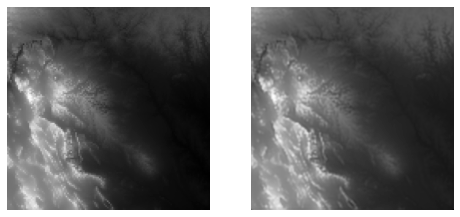

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Sobel Operation')
ax1.axis('off')
ax1.imshow(hr_sub[1].squeeze(), cmap='Greys_r')
ax2.axis('off')
ax2.imshow(sr[1].cpu().squeeze(), cmap='Greys_r')

In [ ]:
hr_sub[1].min(), hr_sub[1].max()

(tensor(0.0605), tensor(0.2970))

In [ ]:
sr[1].min(), sr[1].max()

(tensor(0.0421, device='cuda:0'), tensor(0.3023, device='cuda:0'))